<h1>
    <font color=0000FF>
        Using Metabolites in the Wastewater to measure Drug Consumption - Time Series Forecast
    </font>
</h1>
<h3>
    <font color=89CFF0>
        An Open Source Data Project using Data from the European Monitoring Centre for Drugs and Drug Addiction (EMCDDA) and the SCORE network
    </font>
</h3>      


<img src="https://cdn.pixabay.com/photo/2019/03/20/09/55/road-4068061_960_720.jpg">
Picture taken from <a href="https://pixabay.com/de/photos/stra%c3%9fe-weg-death-valley-wolken-4068061/">Pixabay</a>, from the user <a href="https://pixabay.com/de/users/jplenio-7645255/">"jplenio"</a>.

<h2>
    <font color=0096FF>
        Content & Structure<a id='start'></a>
    </font>
</h2>
<h3>
    <font color=0096FF>
        <p>
            <a href='#first_chapter'>1. Library and Data Import</a>         
        <p>
            <a href='#second_chapter'>2. Preparing the Dataframe</a>
        <p>
            <a href='#third_chapter'>3. Time Series - Preparing the Forecast by Testing for Staionarity</a>
        <p>
            <a href='#fourth_chapter'>4. Time Series - Preparing the Forecast by Stationarizing</a>
        <p>
            <a href='#fifth_chapter'>5. Time Series Forecast</a>
        <p> 
            <a href='#sixth_chapter'>6. Discussing the Results</a>
    </font>
</h3>  

<h3>
    <font color=0096FF>
        Recap
    </font>
</h3>
<p>
    At this point we already tested the hypothesis, created a gespatial analysis, and worked with a regression/clustering model. In this notebook a time series forecast will be created.
<p>


<h2>
    <font color=0096FF>
        <a href='#start'>1. Library and Data Import</a><a id='first_chapter'></a>
    </font>
</h2>

In [170]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import quandl
from datetime import datetime
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ARIMA
from statsmodels.tsa.api import ARMA
from IPython.core.interactiveshell import InteractiveShell

In [2]:
# Setting up options

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
# Setting up the path for import/export/etc.

path = r'X:/Data_Analytic/JUPYTER/Achievement 6'

In [4]:
# Importing dataframe

df_wastewater = pd.read_pickle(os.path.join(path, '02 Data', '02 Prepared Data', 'df_wastewater_tagged_post_6-3.pkl'))

In [5]:
# Checking imported dataframe

df_wastewater.head()
df_wastewater.shape
df_wastewater.isnull().sum()

year       metabolite SiteID country  city   latitude  longitude  \
0  2021      amphetamine  AT001      AT  Graz  47.070713  15.439504   
1  2021         cannabis  AT001      AT  Graz  47.070713  15.439504   
2  2021          cocaine  AT001      AT  Graz  47.070713  15.439504   
3  2021             MDMA  AT001      AT  Graz  47.070713  15.439504   
4  2021  methamphetamine  AT001      AT  Graz  47.070713  15.439504   

   population  Wednesday  Thursday  Friday  Saturday  Sunday  Monday  Tuesday  \
0      487040      47.15     37.48   37.95     38.02   38.14   35.82    35.45   
1      487040      54.77     80.42    60.1     53.88   50.46   77.04   233.51   
2      487040      127.6    121.48  137.75    174.94  179.55  117.31   111.91   
3      487040       5.82      4.53    5.27     16.56   17.37   10.14     7.83   
4      487040      12.44     11.24   14.99      9.33   18.66    9.33    15.66   

   Weekday mean  Weekend mean  Daily mean  avg diff weekend-weekday  \
0         40.03         37.48       38.57                     -2.55   
1         122.9         60.37       87.17                    -62.53   
2        120.33        152.39      138.65                     32.06   
3          6.06         12.33        9.64                      6.27   
4         13.11         13.08       13.09                     -0.03   

   Consumption flag     Name  
0   mid consumption  Austria  
1   mid consumption  Austria  
2  high consumption  Austria  
3   mid consumption  Austria  
4   mid consumption  Austria

(2569, 21)

year                        0
metabolite                  0
SiteID                      0
country                     0
city                        0
latitude                    0
longitude                   0
population                  0
Wednesday                   0
Thursday                    0
Friday                      0
Saturday                    0
Sunday                      0
Monday                      0
Tuesday                     0
Weekday mean                0
Weekend mean                0
Daily mean                  0
avg diff weekend-weekday    0
Consumption flag            0
Name                        0
dtype: int64

<h2>
    <font color=0096FF>
        <a href='#start'>2. Preparing the Dataframe</a><a id='second_chapter'></a>
    </font>
</h2>

There are a few things to consider, before running into the time series forecast:
<ul>
    <li>
        There are multiple measures for every year
    </li>
    <li>
        There are multiple measures for different measurement sites for every year
    </li>
    <li>
        There are multiple measures for 5 different drugs for different measurement sites for every year
    </li>
</ul>
<p>
    This is problematic, because although most of the time we have 7 different measures for the specific years, we don't really know if these measurements are chronological. We might suggest, since the first day is 'Wednesday' that the measurements always start on a Wednesday, but we can't be sure.
<p>
    <b>Therefore, the plan is to assess the situation of how many yearly data points are available.</b>
<p>

In [6]:
# First splitting into the specific drugs - cocaine and MDMA are the two with the most observations

df_wastewater['metabolite'].value_counts()

cocaine            602
MDMA               590
methamphetamine    586
amphetamine        576
cannabis           215
Name: metabolite, dtype: Int64

In [7]:
# Getting an idea of which country actually has a record for each year

for i in list(dict.fromkeys(df_wastewater['Name'].tolist())):
    print(i,len(df_wastewater.loc[df_wastewater['Name']==i].groupby(by='year')))

Austria 7
Belgium 11
Switzerland 10
Cyprus 8
Czech Republic 10
Denmark 6
Spain 11
Finland 10
France 11
United Kingdom 9
Greece 9
Croatia 11
Italy 11
Lithuania 5
Latvia 3
Netherlands 11
Norway 11
Poland 4
Portugal 9
Sweden 7
Slovenia 5
Slovakia 7
Turkey 4
Estonia 1
Germany 9
Iceland 6
Republic of Serbia 2
Malta 1
Bosnia and Herzegovina 1
Romania 1


In [8]:
# Taking the countries with 11 yearly records and looking at what drugs these measures containt

list_11_records = ['Belgium','Spain','France','Croatia','Italy','Netherlands','Norway']

for g in list_11_records:
    print(g)
    for i in list(dict.fromkeys(df_wastewater['metabolite'].tolist())):
        print(i,len(df_wastewater.loc[(df_wastewater['Name']==g)&(df_wastewater['metabolite']==i)].groupby(by='year')))
    print('')

Belgium
amphetamine 11
cannabis 3
cocaine 11
MDMA 11
methamphetamine 11

Spain
amphetamine 11
cannabis 7
cocaine 11
MDMA 11
methamphetamine 11

France
amphetamine 11
cannabis 7
cocaine 11
MDMA 10
methamphetamine 11

Croatia
amphetamine 11
cannabis 7
cocaine 11
MDMA 11
methamphetamine 10

Italy
amphetamine 10
cannabis 7
cocaine 11
MDMA 11
methamphetamine 11

Netherlands
amphetamine 11
cannabis 6
cocaine 11
MDMA 11
methamphetamine 11

Norway
amphetamine 10
cannabis 1
cocaine 10
MDMA 11
methamphetamine 11



[Text(0.5, 1.0, 'Belgium')]

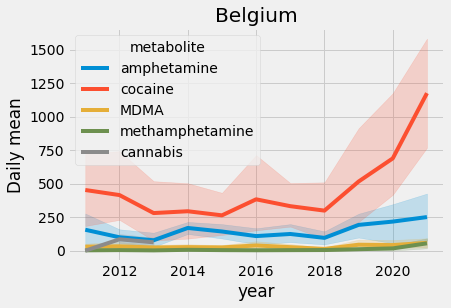

[Text(0.5, 1.0, 'Spain')]

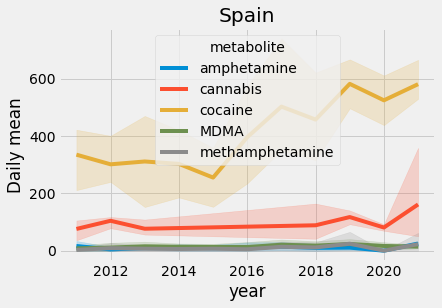

[Text(0.5, 1.0, 'France')]

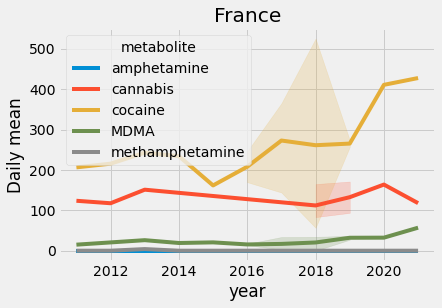

[Text(0.5, 1.0, 'Croatia')]

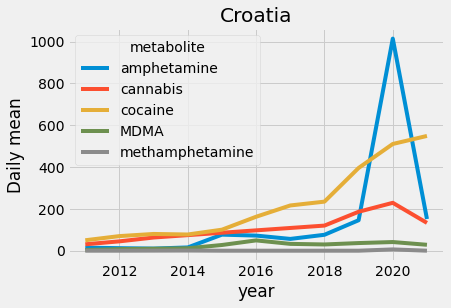

[Text(0.5, 1.0, 'Italy')]

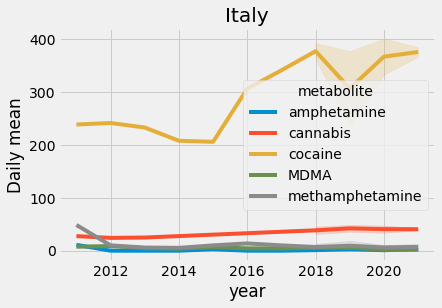

[Text(0.5, 1.0, 'Netherlands')]

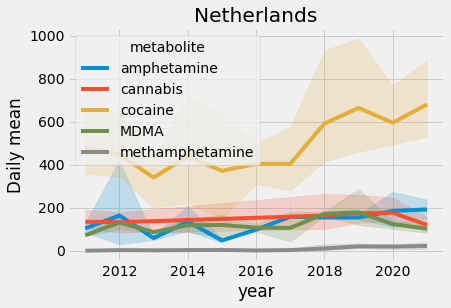

[Text(0.5, 1.0, 'Norway')]

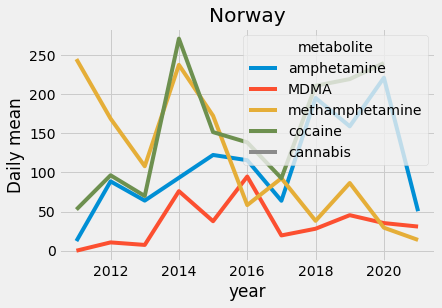

In [9]:
# To get a better overview, a lineplot is created for each country

for i in list_11_records:
    sns.lineplot(x='year', y='Daily mean', hue='metabolite', data = df_wastewater.loc[df_wastewater['Name']==i]).set(title=i);
    plt.show();

<h3>
    <i>Intermission</i>
</h3>
<p>
    Using the linecharts, we can not only see the mean of consumption throughout the years of the specific countries, but also if there are multiple measures available and the range of these measures. Out of the list of countries, 3 have multiple measures throughout the years: Belgium, Spain, and Netherlands. To reduce the extent of the coming procedure, Spain is going to be removed from the further proceedings. If we remember the contents of the notebook regarding the geospatial analysis, we can see, that Spain had a rather low consumption rate in comparison with the other countries.
<p>
    Now, two times two dataframes are created. Two for each country and two for the specific metabolites: Cocaine and MDMA. Since the focus of the analysis was based around these two, the focus for this notebook won't change either. However, Since we will have multiple measures for the years, the mean of all daily means will be used.

In [10]:
# Creating the specific dataframes

country_list = ['Belgium','Netherlands']
drug_list = ['cocaine','MDMA']
df_ts_list = []
df_ts_name_list = ['Cocaine in Belgium','MDMA in Belgium','Cocaine in Netherlands','MDMA in Netherlands']

for i in country_list:
    for g in drug_list :
        df_ts_list.append(pd.DataFrame(df_wastewater.loc[(df_wastewater['metabolite']==g)&(df_wastewater['Name']==i)].groupby(by='year')['Daily mean'].mean()))

In [11]:
# Looking at the specific dataframes

for i in range(0,4):
    print(df_ts_name_list[i])
    df_ts_list[i].head(11)

Cocaine in Belgium


Daily mean
year             
2011   452.750000
2012   414.956667
2013   280.680000
2014   294.222500
2015   263.711429
2016   383.266000
2017   332.127143
2018   298.982000
2019   515.964000
2020   688.753333
2021  1174.980000

MDMA in Belgium


Daily mean
year            
2011   29.795000
2012   32.556667
2013   23.838333
2014   26.742500
2015   24.322857
2016   39.026000
2017   26.354286
2018   13.297500
2019   44.602000
2020   41.903333
2021   58.775000

Cocaine in Netherlands


Daily mean
year            
2011  479.286667
2012  448.363333
2013  339.593333
2014  439.136667
2015  370.953333
2016  404.115000
2017  403.956000
2018  591.296667
2019  663.940000
2020  595.073333
2021  679.996667

MDMA in Netherlands


Daily mean
year            
2011   71.960000
2012  130.850000
2013   86.180000
2014  118.240000
2015  119.740000
2016  107.245000
2017  106.006000
2018  171.645000
2019  178.746667
2020  123.200000
2021  102.876667

<h2>
    <font color=0096FF>
        <a href='#start'>3. Time Series - Preparing the Forecast by Testing for Staionarity</a><a id='third_chapter'></a>
    </font>
</h2>

Now, that the dataframes are ready, we're going to prepare for the time series forecast by testing the dataframes stationarity.

In [12]:
# Preparing for Decomposition by resetting index and implementing a pandas datetime column, using a 'fake' date column

for i in range(0,4):
    df_ts_list[i] = df_ts_list[i].reset_index()

In [13]:
# Creating the 'fake' list

fake_year_list = []

for i in df_ts_list[0]['year'].tolist():
    fake_year_list.append(str(i)+'-01-01')

In [14]:
# Testing the 'fake' list

fake_year_list

['2011-01-01',
 '2012-01-01',
 '2013-01-01',
 '2014-01-01',
 '2015-01-01',
 '2016-01-01',
 '2017-01-01',
 '2018-01-01',
 '2019-01-01',
 '2020-01-01',
 '2021-01-01']

In [15]:
# Installing the 'fake' list as a pandas datetime column

for i in range(0,4):
    df_ts_list[i]['datetime'] = pd.to_datetime(fake_year_list)
    df_ts_list[i] = df_ts_list[i].set_index('datetime')
    df_ts_list[i].drop(['year'],axis=1,inplace=True)
    df_ts_list[i].head()

Daily mean
datetime              
2011-01-01  452.750000
2012-01-01  414.956667
2013-01-01  280.680000
2014-01-01  294.222500
2015-01-01  263.711429

Daily mean
datetime              
2011-01-01   29.795000
2012-01-01   32.556667
2013-01-01   23.838333
2014-01-01   26.742500
2015-01-01   24.322857

Daily mean
datetime              
2011-01-01  479.286667
2012-01-01  448.363333
2013-01-01  339.593333
2014-01-01  439.136667
2015-01-01  370.953333

Daily mean
datetime              
2011-01-01       71.96
2012-01-01      130.85
2013-01-01       86.18
2014-01-01      118.24
2015-01-01      119.74

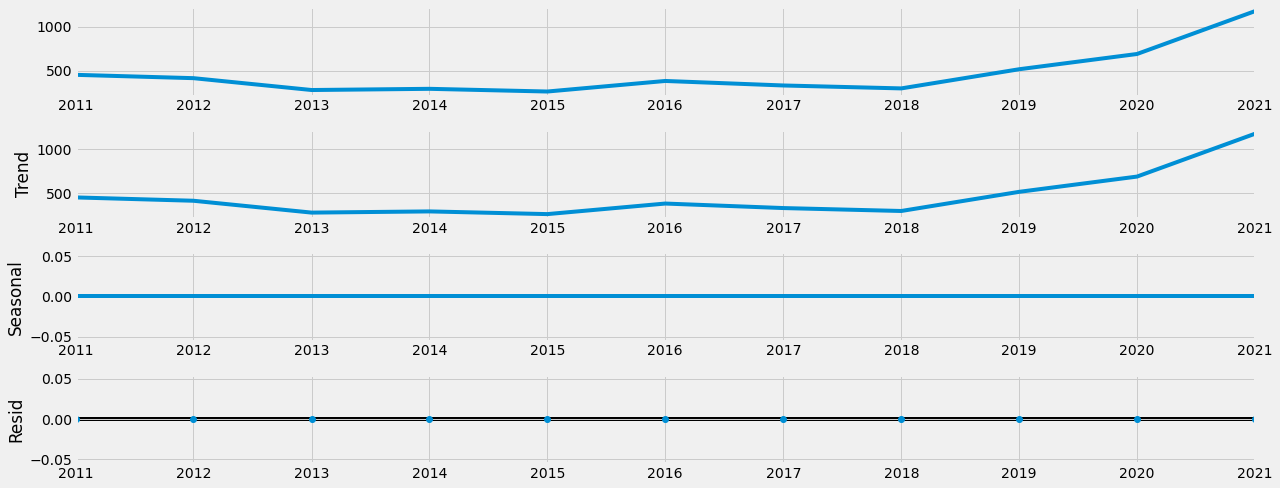

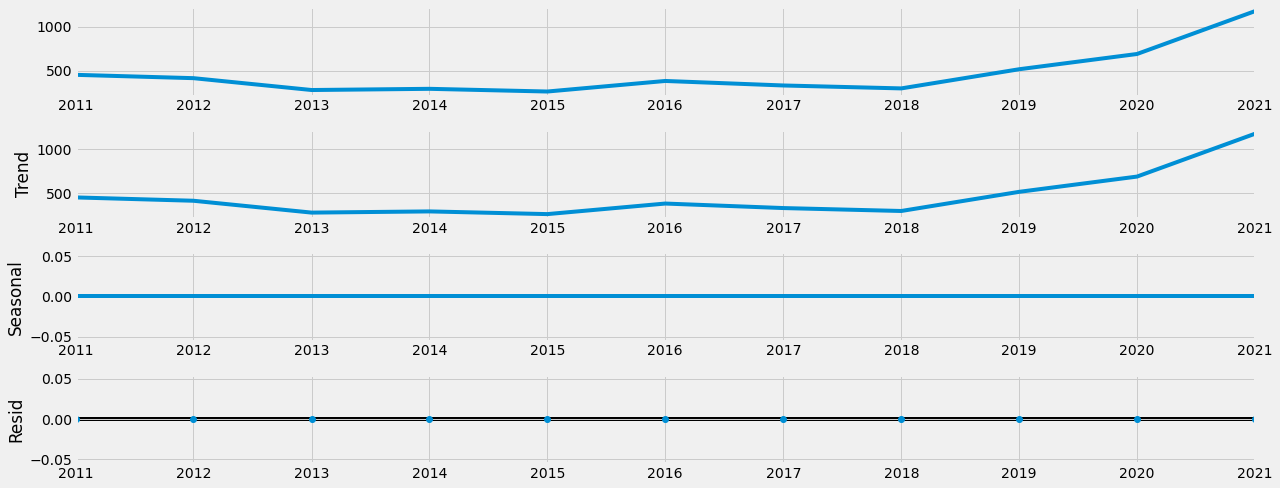

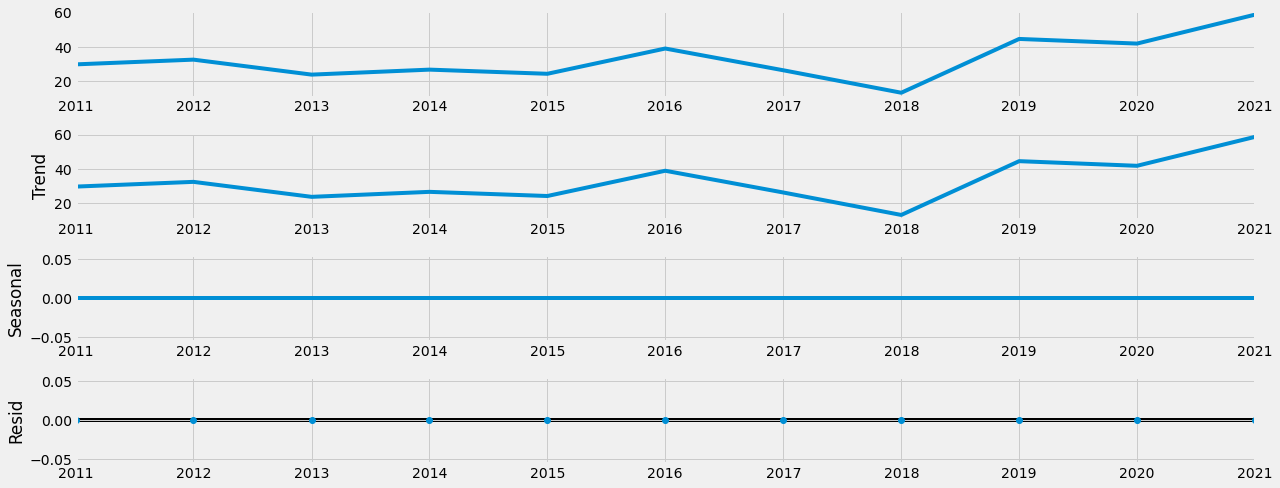

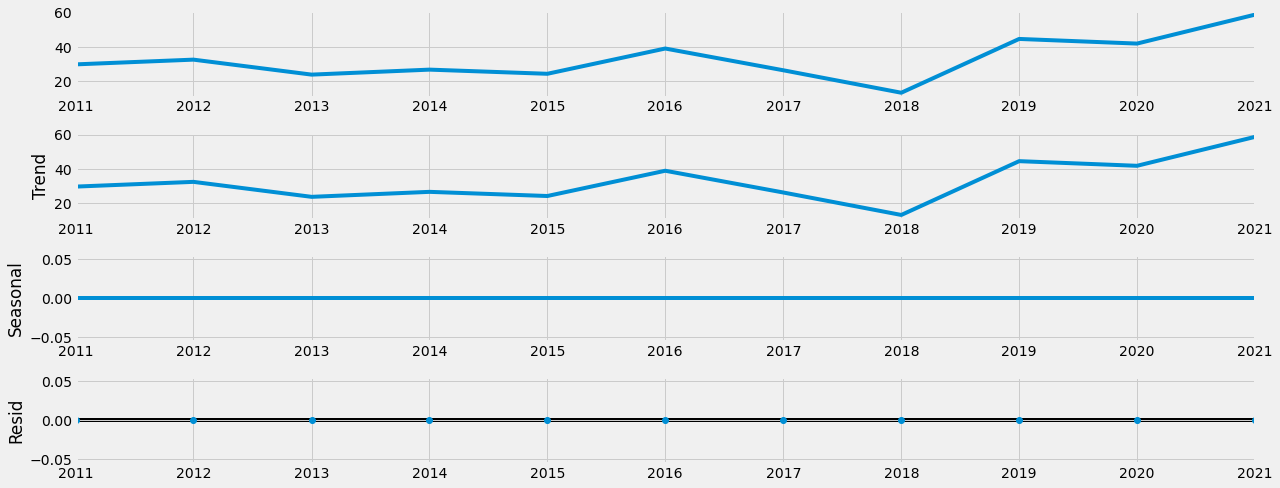

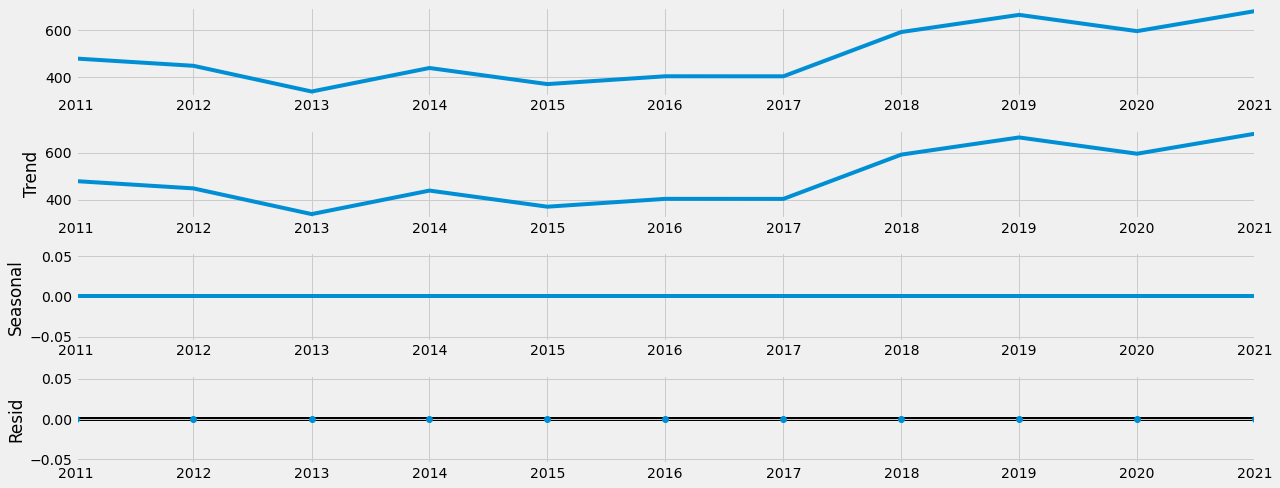

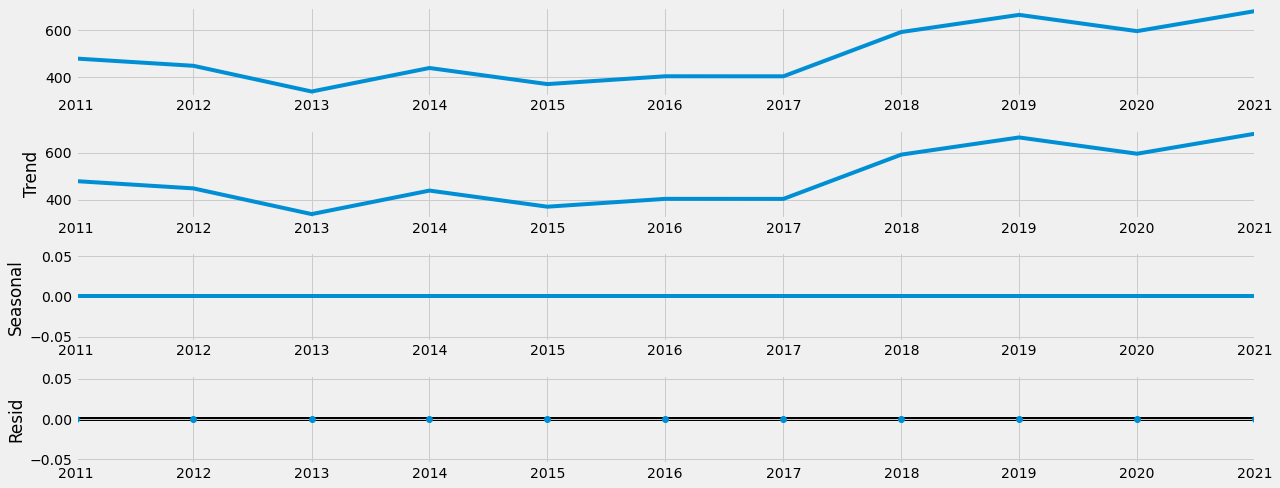

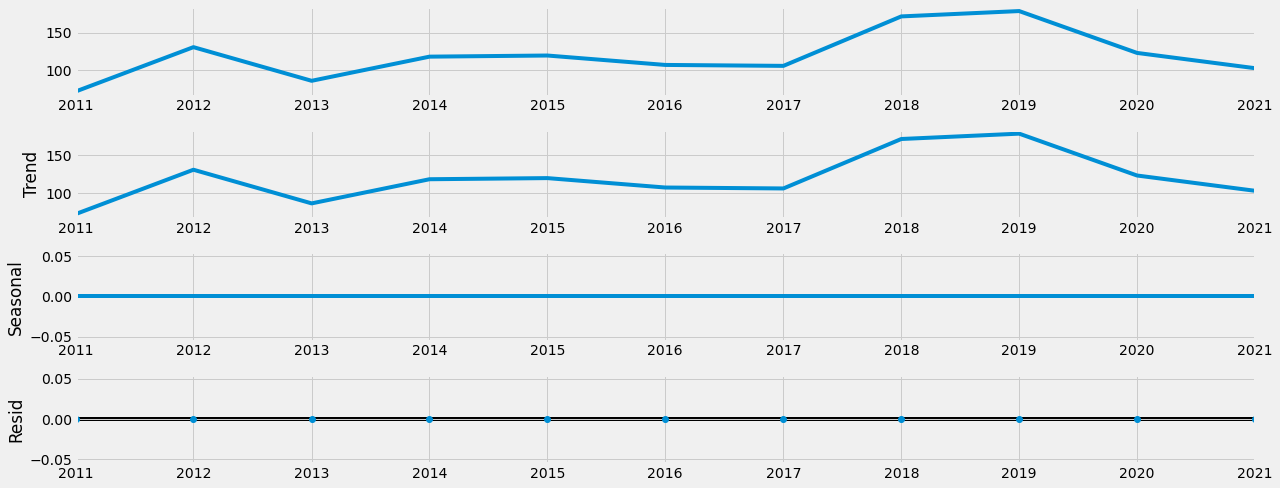

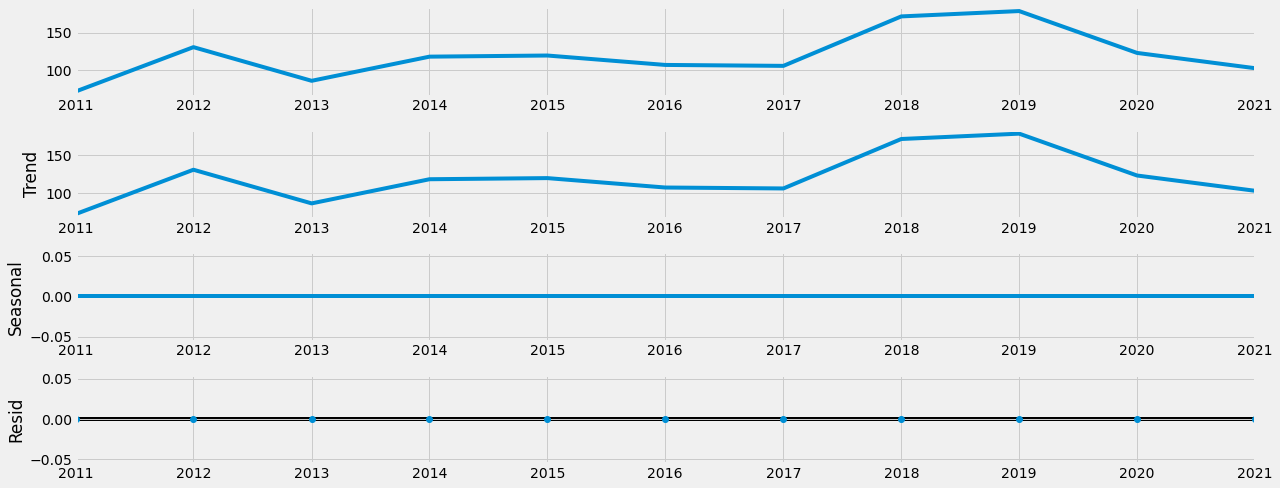

In [16]:
# Creating the decomposition charts

decomp_list = []

for i in range(0,4):
    decomp_list.append(sm.tsa.seasonal_decompose(df_ts_list[i], model='additive'))
    rcParams['figure.figsize']=18,7
    decomp_list[i].plot()
    plt.show()

In [17]:
# Creating the dickey fuller test function

def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationary test:')
    test = adfuller(timeseries,autolag='AIC')
    result = pd.Series(test[0:4],index=['Test Statistic','p-value','Number of Lags Used','Number of Obeservations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print(result)

In [18]:
# Dickey Fuller Test

for i in range(0,4):
    dickey_fuller(df_ts_list[i]['Daily mean'])
    print('')

Dickey-Fuller Stationary test:
Test Statistic                   2.061247
p-value                          0.998747
Number of Lags Used              0.000000
Number of Obeservations Used    10.000000
Critical Value (1%)             -4.331573
Critical Value (5%)             -3.232950
Critical Value (10%)            -2.748700
dtype: float64

Dickey-Fuller Stationary test:
Test Statistic                  -1.429969
p-value                          0.567827
Number of Lags Used              0.000000
Number of Obeservations Used    10.000000
Critical Value (1%)             -4.331573
Critical Value (5%)             -3.232950
Critical Value (10%)            -2.748700
dtype: float64

Dickey-Fuller Stationary test:
Test Statistic                  -0.616225
p-value                          0.867274
Number of Lags Used              0.000000
Number of Obeservations Used    10.000000
Critical Value (1%)             -4.331573
Critical Value (5%)             -3.232950
Critical Value (10%)            -2.

<h3>
    <i>Intermission</i>
</h3>
<p>
    Unsurprisingly, simply using the daily mean, is basically providing a non-stationary dataframe. There's no seasonality, which will be difficult in creating a time series forecast. To help the algorithm, I will synthetically increase the data at hand, using the data I have.
<p>
    We have different measurements for 7 weekdays. But since there's no information on which exact date these measurements were taken, I will assume, that these measurements were taken after a period of around 52 days, starting on the 1st of January each year.

In [19]:
# Creating the specific dataframes

country_listwk = ['Belgium','Netherlands']
drug_listwk = ['cocaine','MDMA']
df_ts_listwk = []
df_ts_name_listwk = ['Cocaine in Belgium','MDMA in Melgium','Cocaine in Netherlands','MDMA in Netherlands']
df_day_listwk = ['Wednesday','Thursday','Friday','Saturday','Sunday','Monday','Tuesday']

for i in country_listwk:
    for g in drug_listwk :
        df_ts_listwk.append(pd.DataFrame(df_wastewater.loc[(df_wastewater['metabolite']==g)&(df_wastewater['Name']==i)].groupby(by='year')[df_day_listwk].mean()))

In [20]:
# Checking the dataframes

for i in range(0,4):
    df_ts_listwk[i].head()

Wednesday    Thursday      Friday    Saturday      Sunday      Monday  \
year                                                                           
2011      368.02      399.21     471.215     510.425     581.975     464.575   
2012  378.336667  330.676667  422.686667      463.57       451.6  442.256667   
2013     268.885      252.31  262.641667  314.308333      341.67  283.591667   
2014    212.3225    251.7775      296.72     308.655     345.165      394.96   
2015      239.16      235.66  253.334286      285.82  325.938571  265.637143   

         Tuesday  
year              
2011     373.835  
2012  415.556667  
2013     237.535  
2014     249.975  
2015  240.432857

Wednesday   Thursday     Friday   Saturday     Sunday     Monday  \
year                                                                     
2011       16.4      15.31     18.795      45.78     56.395      32.85   
2012  23.643333  17.863333  22.786667  40.143333      50.09      39.48   
2013  18.273333      13.97  14.803333  23.271667     44.435  32.468333   
2014     18.335    15.0675      27.47       25.6      37.73     41.115   
2015       17.4  24.198571  17.131429  20.357143  40.764286  29.442857   

        Tuesday  
year             
2011     21.105  
2012      33.91  
2013      18.85  
2014    21.8775  
2015  20.975714

Wednesday    Thursday      Friday    Saturday      Sunday      Monday  \
year                                                                           
2011  431.296667      419.07  527.126667  565.303333  507.026667  235.503333   
2012  416.086667  357.493333       460.4  527.766667      615.91      372.33   
2013       237.5      314.94  495.553333      468.59  351.656667  273.116667   
2014  294.156667  404.126667  379.566667       482.5  513.583333      459.12   
2015      229.18      290.17  409.963333  575.006667  541.366667      238.27   

         Tuesday  
year              
2011      240.31  
2012  388.543333  
2013  235.786667  
2014  413.966667  
2015  312.736667

Wednesday  Thursday  Friday    Saturday      Sunday      Monday  \
year                                                                    
2011     90.315    54.985   52.15       57.02      117.25      30.075   
2012     64.765      61.2  77.275     151.195     299.075      145.66   
2013     55.535    56.585  57.405     126.335     103.405     112.875   
2014     85.455    76.635  74.125       84.96      172.34     173.345   
2015      110.7     43.72   70.64  127.193333  253.783333  136.226667   

        Tuesday  
year             
2011      24.69  
2012    116.785  
2013     91.145  
2014     160.85  
2015  95.923333

In [21]:
# Creating a list containing all columns and their values of the dataframes

duck = ['Wednesday','Thursday','Friday','Saturday','Sunday','Monday','Tuesday'] # just a random name for this variable
week_list = [[],[],[],[]]

for i in range(0,4):
    for g in range(0,7):
        week_list[i].append(df_ts_listwk[i][duck[g]].tolist())

In [22]:
# Splitting the list into smaller lists to have a value for each date

week_list_merge = [[],[],[],[]]

for i in range(0,4):
    for g in range(0,11):
        for x in range(0,7):
            week_list_merge[i].append(week_list[i][x][g])

In [23]:
# Creating a list that has each date needed

year_listwk = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
add_listwk = ['-01-01','-02-22','-04-15','-06-06','-07-28','-09-18','-11-09'] # Format: MM:DD

year_df_listwk = []

for i in year_listwk:
    for g in add_listwk:
        year_df_listwk.append(i+g)

In [24]:
# Testing the results

week_list_merge[0][:7]

[368.02,
 399.21000000000004,
 471.21500000000003,
 510.425,
 581.975,
 464.575,
 373.83500000000004]

In [25]:
# Testing the results

year_df_listwk

['2011-01-01',
 '2011-02-22',
 '2011-04-15',
 '2011-06-06',
 '2011-07-28',
 '2011-09-18',
 '2011-11-09',
 '2012-01-01',
 '2012-02-22',
 '2012-04-15',
 '2012-06-06',
 '2012-07-28',
 '2012-09-18',
 '2012-11-09',
 '2013-01-01',
 '2013-02-22',
 '2013-04-15',
 '2013-06-06',
 '2013-07-28',
 '2013-09-18',
 '2013-11-09',
 '2014-01-01',
 '2014-02-22',
 '2014-04-15',
 '2014-06-06',
 '2014-07-28',
 '2014-09-18',
 '2014-11-09',
 '2015-01-01',
 '2015-02-22',
 '2015-04-15',
 '2015-06-06',
 '2015-07-28',
 '2015-09-18',
 '2015-11-09',
 '2016-01-01',
 '2016-02-22',
 '2016-04-15',
 '2016-06-06',
 '2016-07-28',
 '2016-09-18',
 '2016-11-09',
 '2017-01-01',
 '2017-02-22',
 '2017-04-15',
 '2017-06-06',
 '2017-07-28',
 '2017-09-18',
 '2017-11-09',
 '2018-01-01',
 '2018-02-22',
 '2018-04-15',
 '2018-06-06',
 '2018-07-28',
 '2018-09-18',
 '2018-11-09',
 '2019-01-01',
 '2019-02-22',
 '2019-04-15',
 '2019-06-06',
 '2019-07-28',
 '2019-09-18',
 '2019-11-09',
 '2020-01-01',
 '2020-02-22',
 '2020-04-15',
 '2020-06-

In [26]:
# Checking the results

len(week_list_merge[0])
len(year_df_listwk)

77

77

In [27]:
# Using the two created lists to create another list containing the values of the list saved as a dataframe
# Also resetting index and renaming columns and checking

df_full_list = []

for i in range(0,4):
    df_full_list.append(pd.DataFrame(week_list_merge[i], year_df_listwk))
    df_full_list[i] = df_full_list[i].reset_index()
    df_full_list[i].rename(columns={0:'value','index':'date'},inplace=True)
    df_full_list[i].head()

date    value
0  2011-01-01  368.020
1  2011-02-22  399.210
2  2011-04-15  471.215
3  2011-06-06  510.425
4  2011-07-28  581.975

date   value
0  2011-01-01  16.400
1  2011-02-22  15.310
2  2011-04-15  18.795
3  2011-06-06  45.780
4  2011-07-28  56.395

date       value
0  2011-01-01  431.296667
1  2011-02-22  419.070000
2  2011-04-15  527.126667
3  2011-06-06  565.303333
4  2011-07-28  507.026667

date    value
0  2011-01-01   90.315
1  2011-02-22   54.985
2  2011-04-15   52.150
3  2011-06-06   57.020
4  2011-07-28  117.250

In [28]:
# Preparing the list with the dataframe for the decomposition charts by implementing the datetime column

for i in range(0,4):
    df_full_list[i]['time'] = pd.to_datetime(df_full_list[i]['date'])
    df_full_list[i] = df_full_list[i].set_index('time')
    df_full_list[i].drop(['date'],axis=1,inplace=True)
    df_full_list[i].head()

value
time               
2011-01-01  368.020
2011-02-22  399.210
2011-04-15  471.215
2011-06-06  510.425
2011-07-28  581.975

value
time              
2011-01-01  16.400
2011-02-22  15.310
2011-04-15  18.795
2011-06-06  45.780
2011-07-28  56.395

value
time                  
2011-01-01  431.296667
2011-02-22  419.070000
2011-04-15  527.126667
2011-06-06  565.303333
2011-07-28  507.026667

value
time               
2011-01-01   90.315
2011-02-22   54.985
2011-04-15   52.150
2011-06-06   57.020
2011-07-28  117.250

Cocaine in Belgium


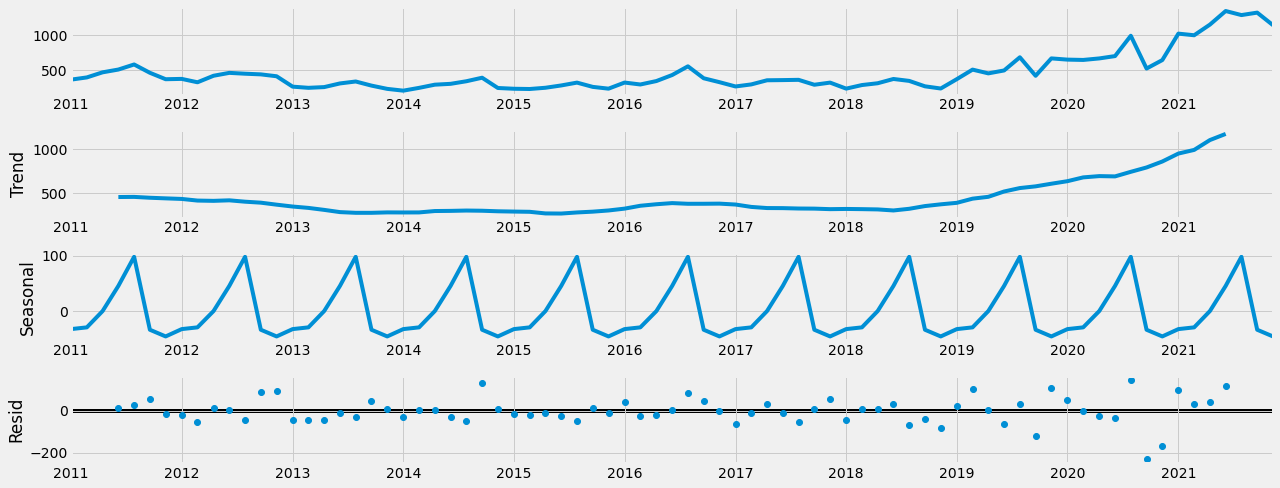

MDMA in Belgium


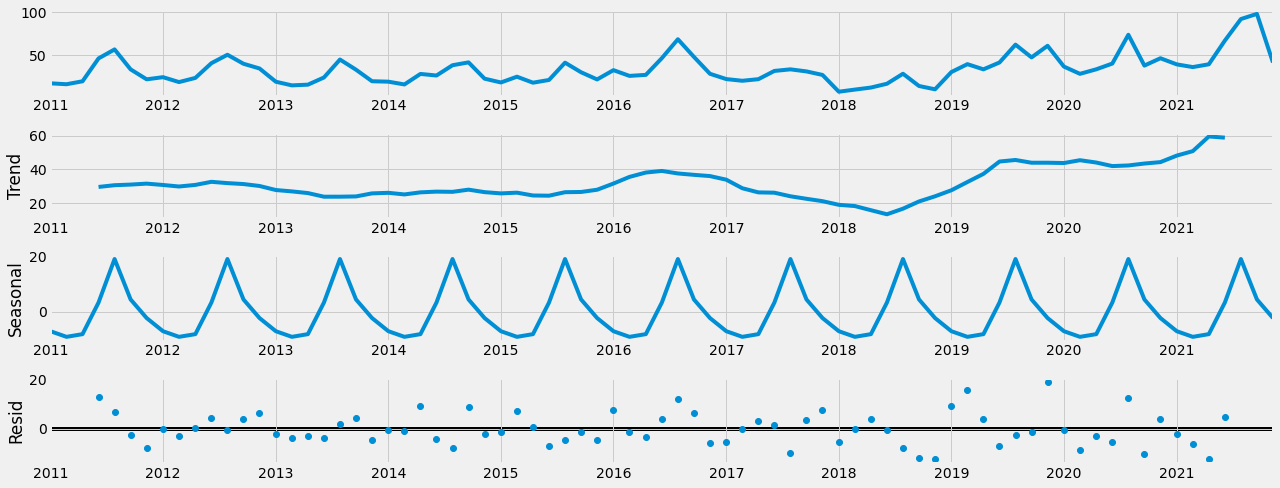

Cocaine in Netherlands


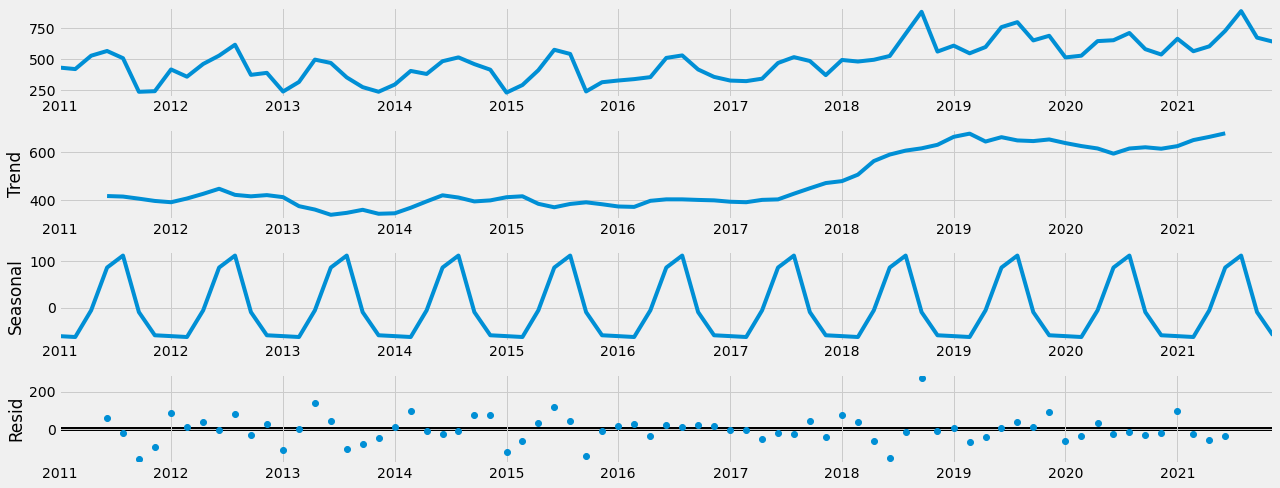

MDMA in Netherlands


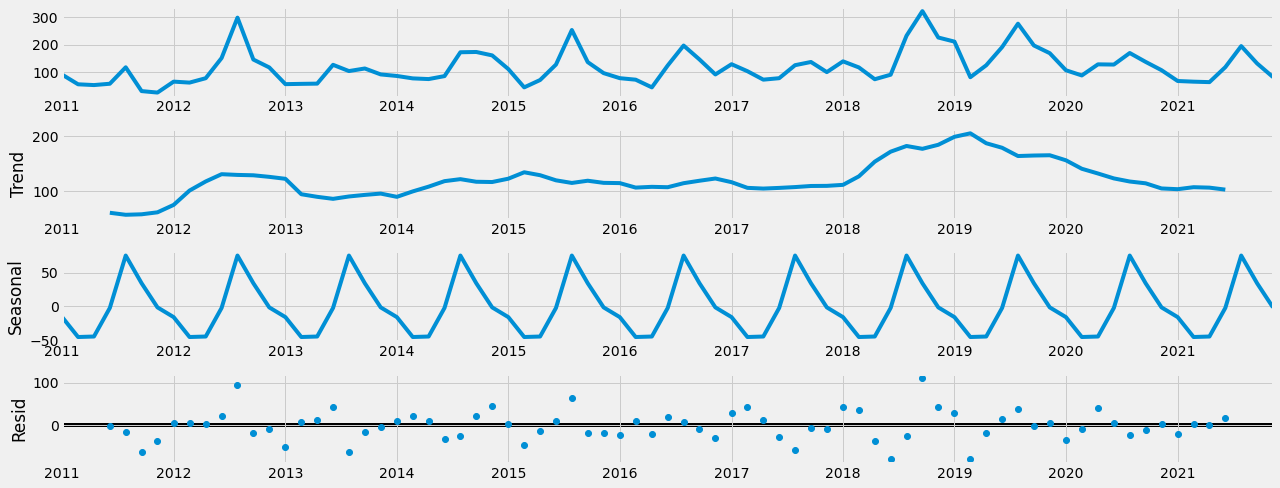

In [29]:
# Creating the decomposition charts, using a list

decomp_full_list = []

for i in range(0,4):
    decomp_full_list.append(sm.tsa.seasonal_decompose(df_full_list[i],model='additive',period=7));
    rcParams['figure.figsize']=18,7;
    print(df_ts_name_list[i])
    output_plot = decomp_full_list[i].plot();
    plt.show();

In [30]:
# Doing the Dickey Fuller test with the list containing the dataframes

for i in range(0,4):
    print(df_ts_name_list[i])
    dickey_fuller(df_full_list[i])
    print('')

Cocaine in Belgium
Dickey-Fuller Stationary test:
Test Statistic                   2.049622
p-value                          0.998734
Number of Lags Used             12.000000
Number of Obeservations Used    64.000000
Critical Value (1%)             -3.536928
Critical Value (5%)             -2.907887
Critical Value (10%)            -2.591493
dtype: float64

MDMA in Belgium
Dickey-Fuller Stationary test:
Test Statistic                  -4.771006
p-value                          0.000062
Number of Lags Used              1.000000
Number of Obeservations Used    75.000000
Critical Value (1%)             -3.520713
Critical Value (5%)             -2.900925
Critical Value (10%)            -2.587781
dtype: float64

Cocaine in Netherlands
Dickey-Fuller Stationary test:
Test Statistic                  -0.107641
p-value                          0.948672
Number of Lags Used              6.000000
Number of Obeservations Used    70.000000
Critical Value (1%)             -3.527426
Critical Value (5%)

Cocaine in Belgium


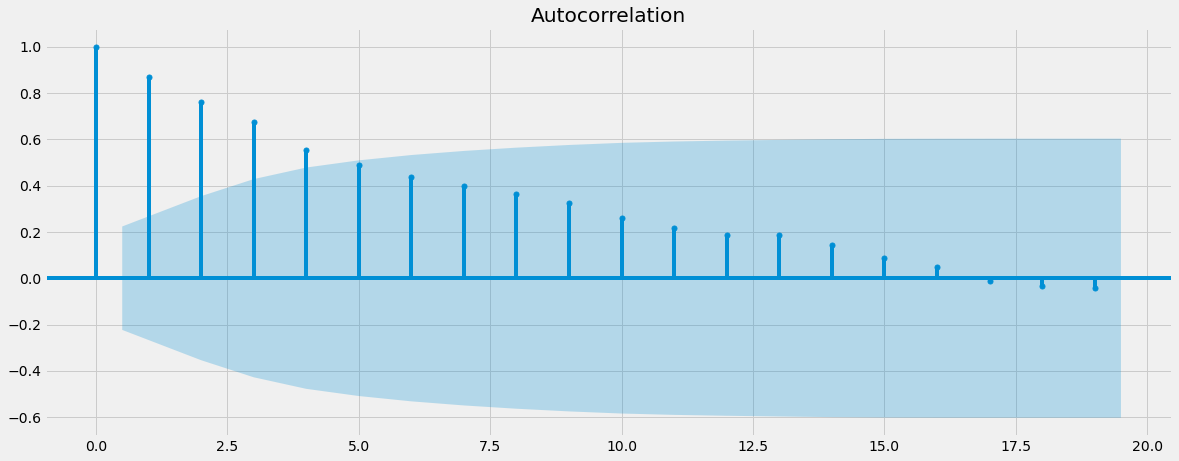

MDMA in Belgium


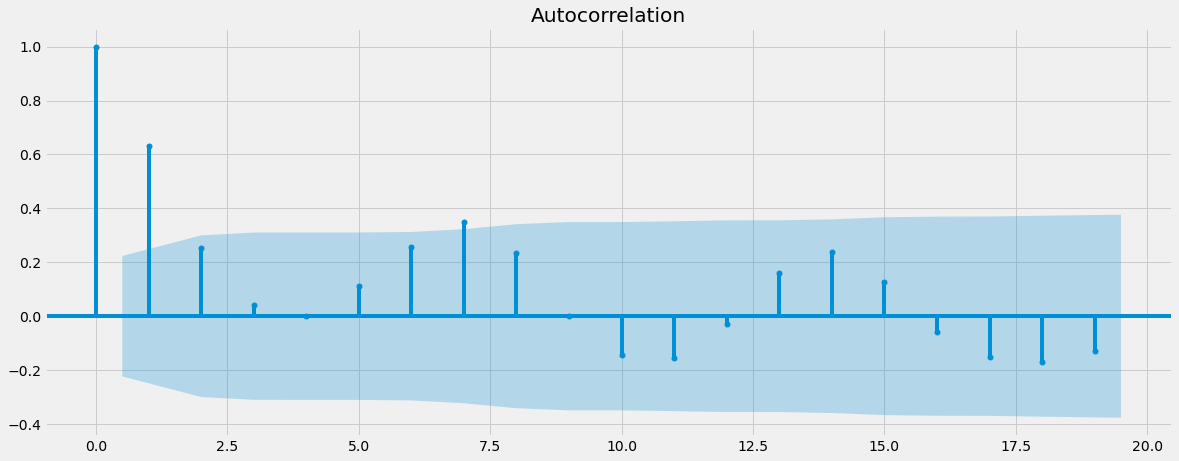

Cocaine in Netherlands


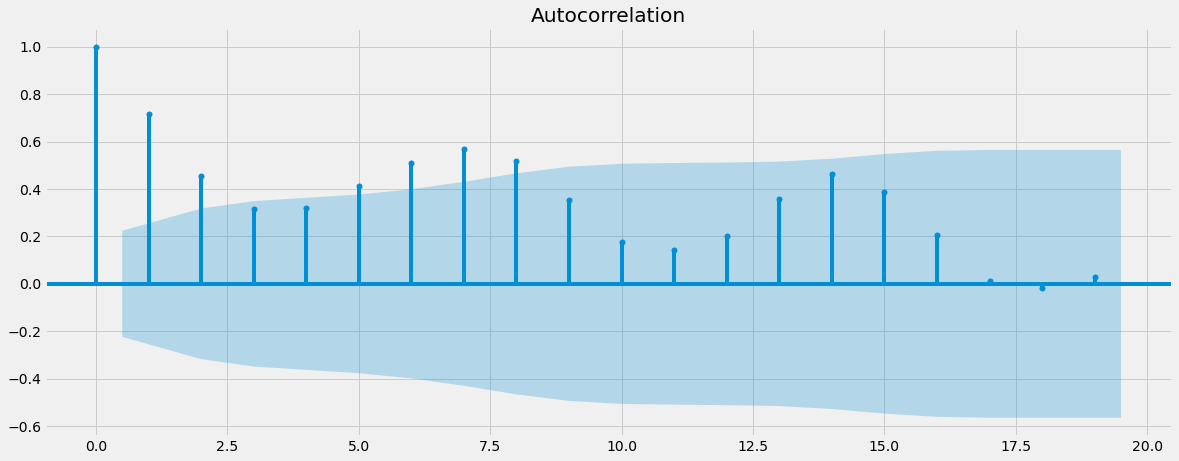

MDMA in Netherlands


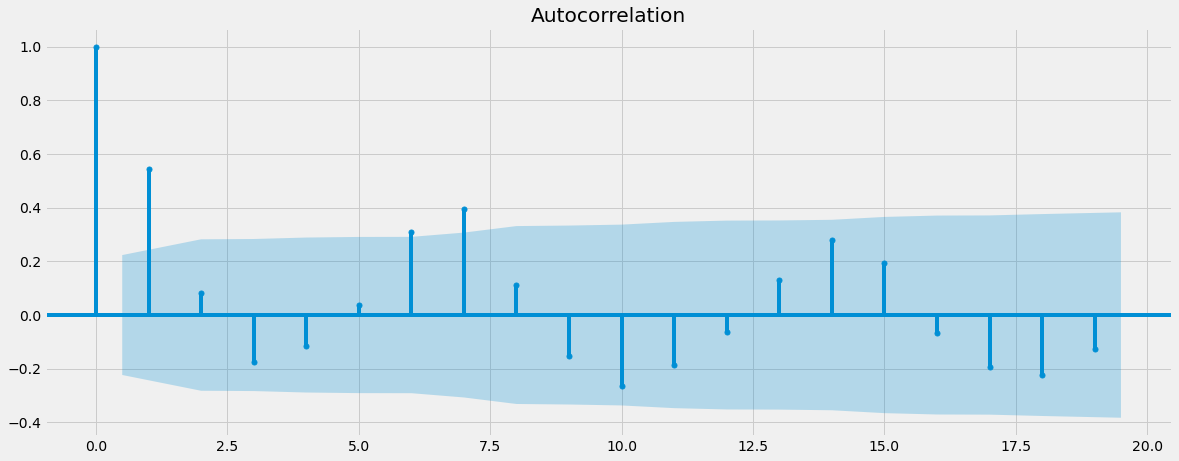

In [31]:
# Looking at the autocorrelation charts

for i in range(0,4):
    rcParams['figure.figsize']=18,7;
    print(df_ts_name_list[i]);
    output_plot = plot_acf(df_full_list[i]);
    plt.show();

As we can see, the implementing of the additional values created a seasonal component to our data, needed for forecasting. The Dickey Fuller test shows, that only the MDMA in Belgium data, doesn't need to be corrected, as the test statistic is even smaller than the 1% critical. The three other dataframes need differencing.
<p>
    The autocorrelation charts look promising as well, since there isn't much correlated data and none with a lag greater than 8.
<p>
    <b>Since I need to work on the single dataframes from now on, I will split up the list with the dataframes.</b>

<h2>
    <font color=0096FF>
        <a href='#start'>4. Time Series - Preparing the Forecast by Stationarizing</a><a id='fourth_chapter'></a>
    </font>
</h2>

In [38]:
# Splitting the dataframes

df_coc_bel = df_full_list[0]
df_mdm_bel = df_full_list[1]
df_coc_net = df_full_list[2]
df_mdm_net = df_full_list[3]

In [39]:
# Differentiating the three dataframes

df_coc_bel = df_coc_bel - df_coc_bel.shift(1)
df_coc_net = df_coc_net - df_coc_net.shift(1)
df_mdm_net = df_mdm_net - df_mdm_net.shift(1)

df_coc_bel.dropna(inplace=True)
df_coc_net.dropna(inplace=True)
df_mdm_net.dropna(inplace=True)

Cocaine in Belgium


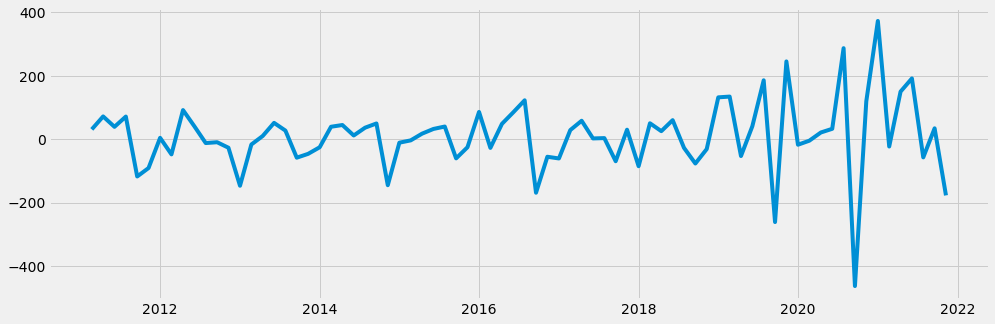

Cocaine in Netherlands


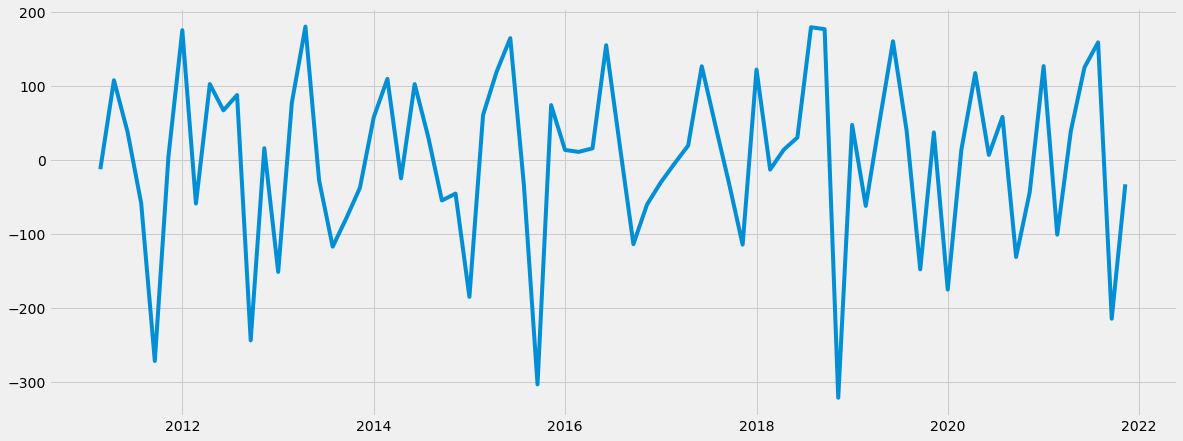

MDMA in Netherlands


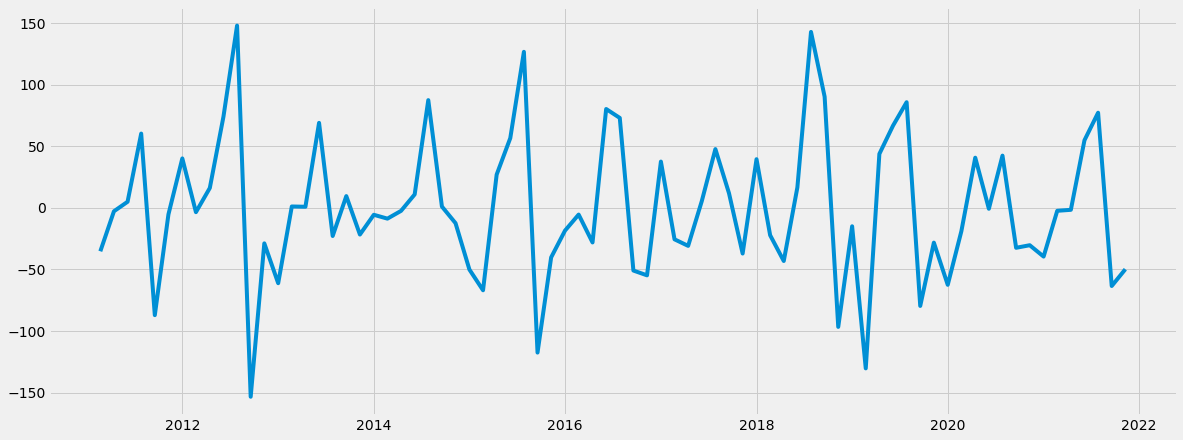

In [40]:
# Plotting the changed dataframes

plt.figure(figsize=(15,5));

print(df_ts_name_list[0])
plt.plot(df_coc_bel);
plt.show();

print(df_ts_name_list[2])
plt.plot(df_coc_net);
plt.show();

print(df_ts_name_list[3])
plt.plot(df_mdm_net);
plt.show();

In [43]:
# Dickey Fuller Tests

print(df_ts_name_list[0])
dickey_fuller(df_coc_bel)
print('')

print(df_ts_name_list[2])
dickey_fuller(df_coc_net)
print('')

print(df_ts_name_list[3])
dickey_fuller(df_mdm_net)

Cocaine in Belgium
Dickey-Fuller Stationary test:
Test Statistic                  -0.332214
p-value                          0.920816
Number of Lags Used             12.000000
Number of Obeservations Used    63.000000
Critical Value (1%)             -3.538695
Critical Value (5%)             -2.908645
Critical Value (10%)            -2.591897
dtype: float64

Cocaine in Netherlands
Dickey-Fuller Stationary test:
Test Statistic                 -7.637159e+00
p-value                         1.938705e-11
Number of Lags Used             5.000000e+00
Number of Obeservations Used    7.000000e+01
Critical Value (1%)            -3.527426e+00
Critical Value (5%)            -2.903811e+00
Critical Value (10%)           -2.589320e+00
dtype: float64

MDMA in Netherlands
Dickey-Fuller Stationary test:
Test Statistic                 -8.572739e+00
p-value                         8.114765e-14
Number of Lags Used             4.000000e+00
Number of Obeservations Used    7.100000e+01
Critical Value (1%)     

Cocaine in Belgium


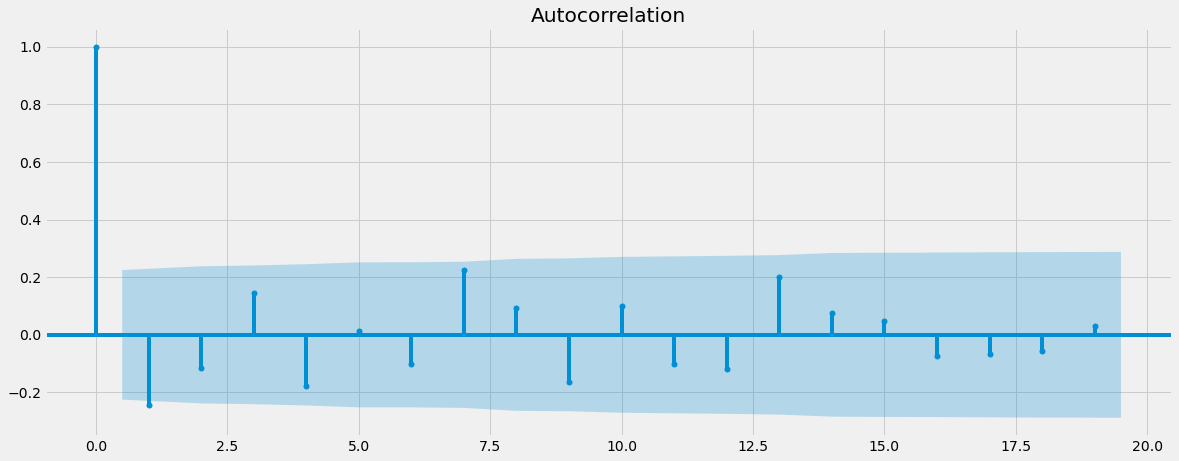

Cocaine in Netherlands


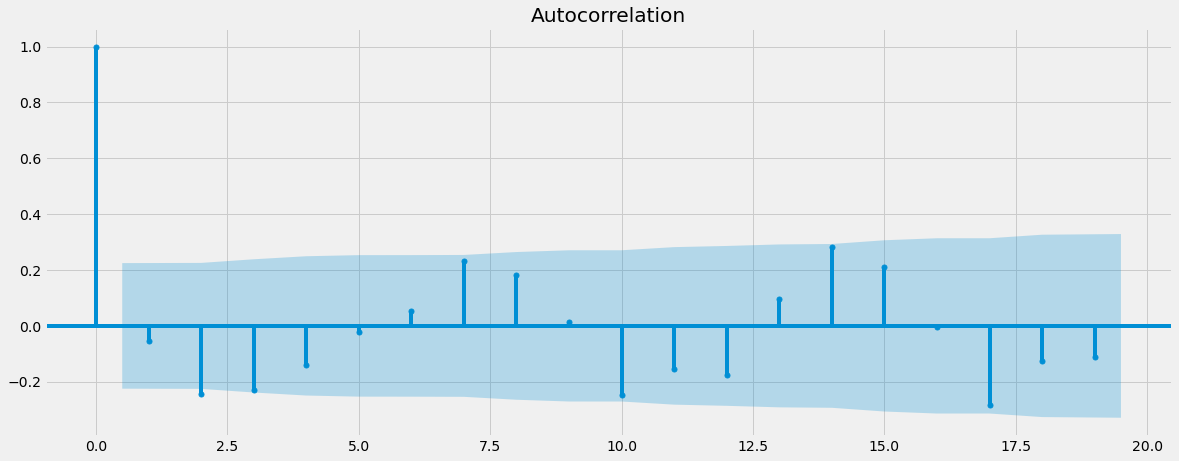

MDMA in Netherlands


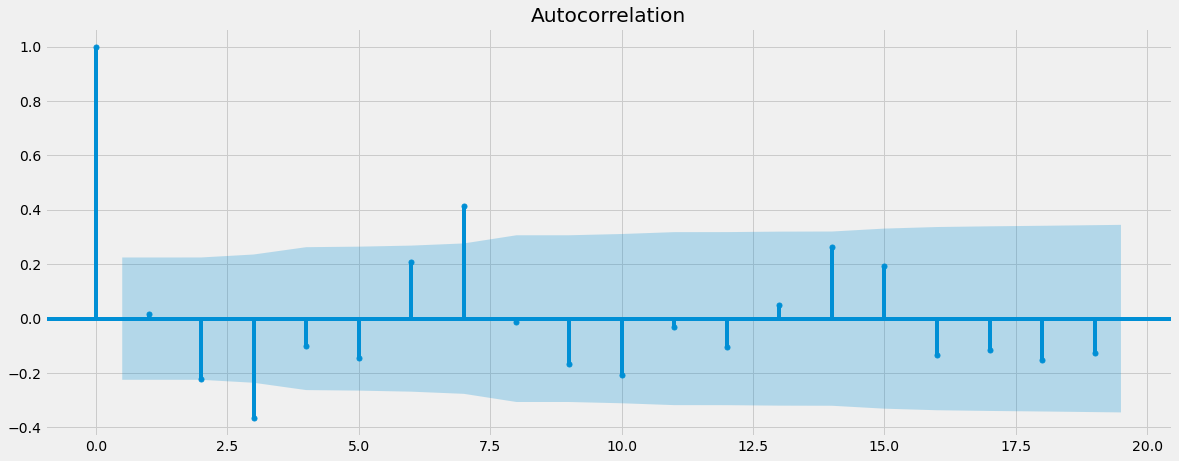

In [45]:
# Autocorrelation charts of the changed data

print(df_ts_name_list[0])
plot_acf(df_coc_bel);
plt.show();

print(df_ts_name_list[2])
plot_acf(df_coc_net);
plt.show();

print(df_ts_name_list[3])
plot_acf(df_mdm_net);
plt.show();

<h3>
    <i>Intermission</i>
</h3>
<p>
    The dataframes regarding the drug consumption in the netherlands both have a test statistic which is smaller than the 1% critical. Therefore these two needed 1 round of correction. The cocaine consumption in belgium dataframe will need more rounds.

Cocaine in Belgium


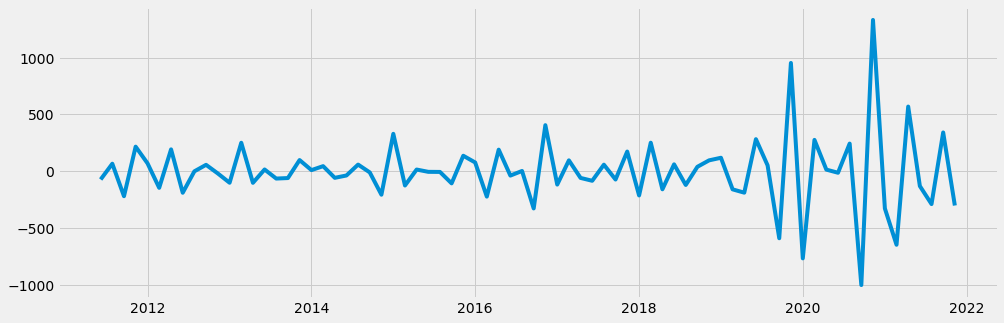

In [47]:
# Next round of correction

df_coc_bel = df_coc_bel - df_coc_bel.shift(1)

df_coc_bel.dropna(inplace=True)

print(df_ts_name_list[0])
plt.figure(figsize=(15,5));
plt.plot(df_coc_bel);
plt.show();

In [49]:
# Dickey Fuller test

print(df_ts_name_list[0])
dickey_fuller(df_coc_bel)

Cocaine in Belgium
Dickey-Fuller Stationary test:
Test Statistic                 -7.902313e+00
p-value                         4.153595e-12
Number of Lags Used             9.000000e+00
Number of Obeservations Used    6.400000e+01
Critical Value (1%)            -3.536928e+00
Critical Value (5%)            -2.907887e+00
Critical Value (10%)           -2.591493e+00
dtype: float64


Cocaine in Belgium


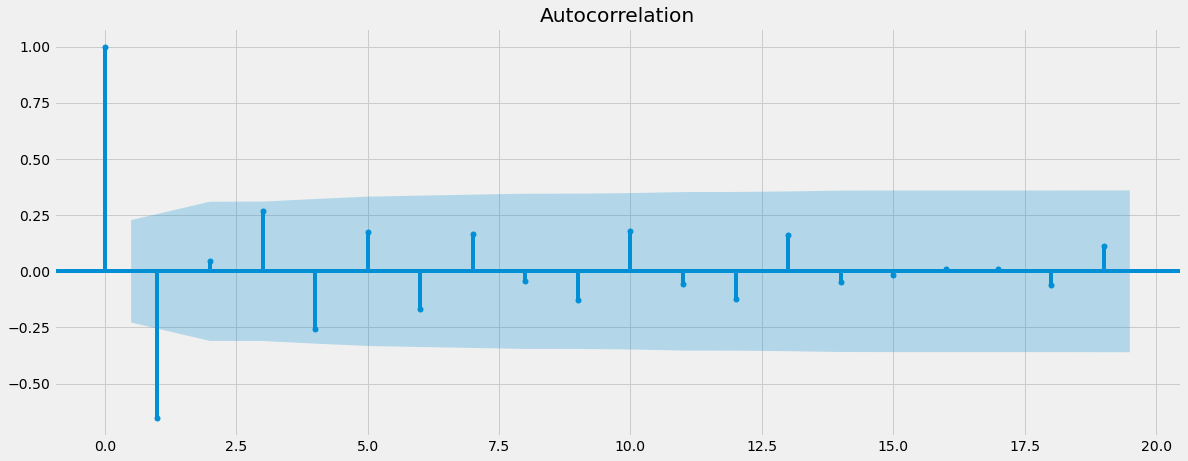

In [50]:
# Autocorrelation chart cocaine belgium

print(df_ts_name_list[0])
plot_acf(df_coc_bel);
plt.show();

<h3>
    <i>Recap before forecast</i>
</h3>
<p>
    Now, all dataframes have a test statistic which is below the 1% critical value. Therefore we can begin with the forecast. The cocaine in belgium dataframe needed 2 correction rounds, the mdma in belgium needed 0 correction rounds, and both, cocaine and mdma in netherlands needed 1 correctino round.

<h2>
    <font color=0096FF>
        <a href='#start'>5. Time Series Forecast</a><a id='fifth_chapter'></a>
    </font>
</h2>

First of all, we'll define the parameters, then we work on the forecast.

<h3>
    Defining the parameters
</h3>

Cocaine in Belgium


X:\Data_Analytic\ANACONDA\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 4500x4500 with 0 Axes>

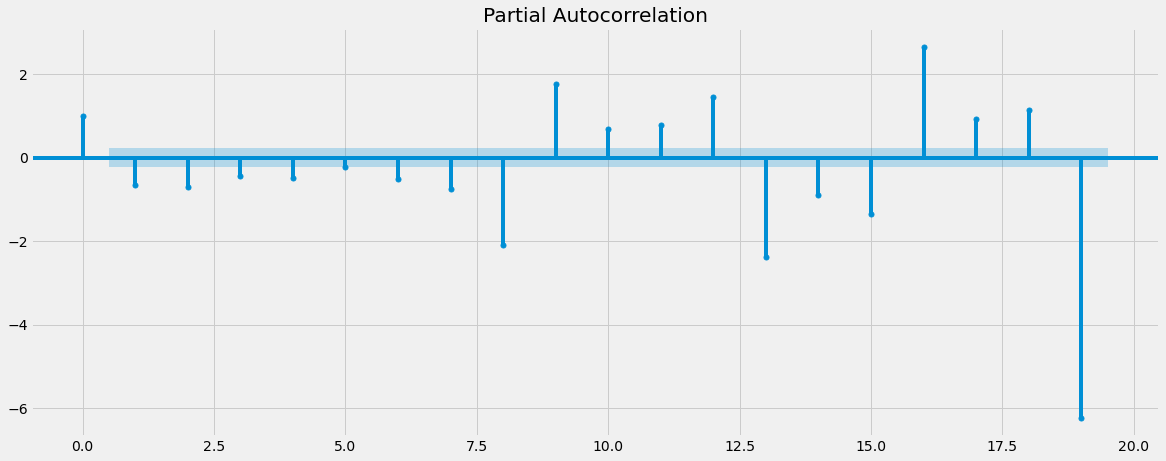

MDMA in Belgium


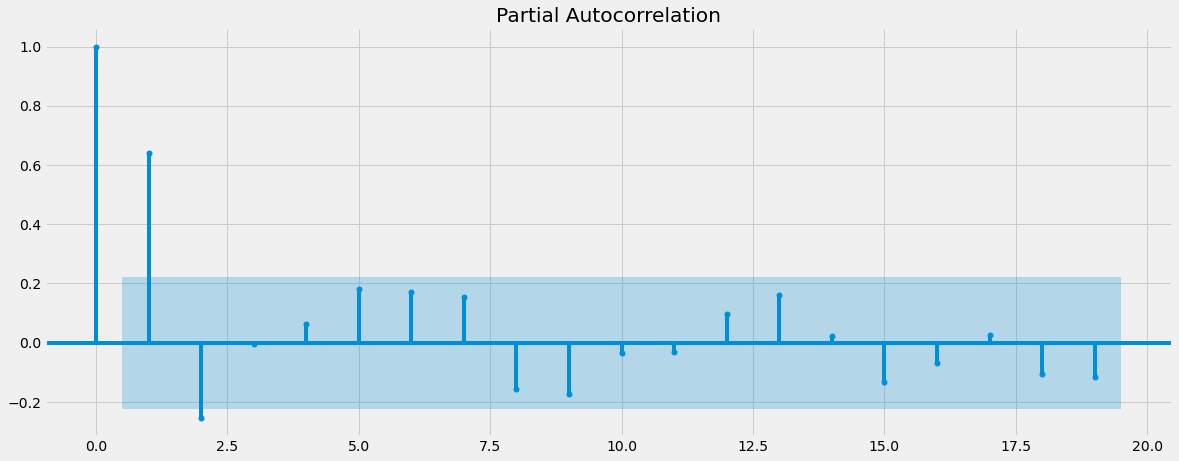

Cocaine in Netherlands


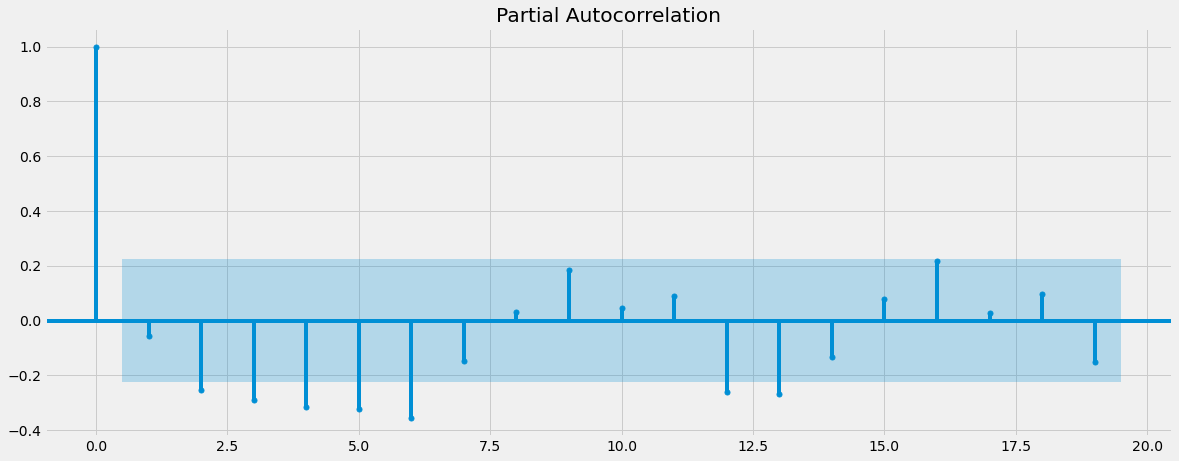

MDMA in Netherlands


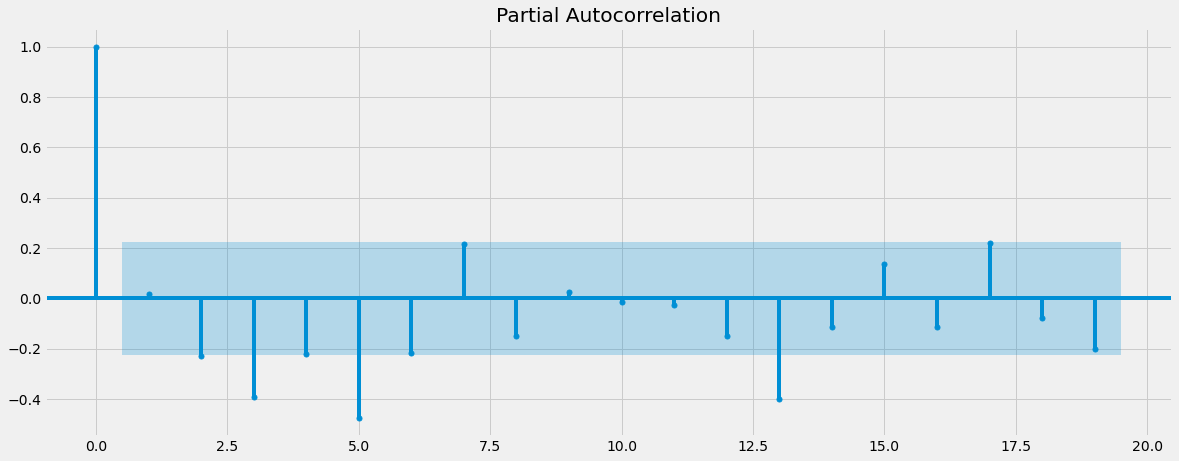

In [51]:
# Creating the Partial Autocorrelation charts to determine p

plt.figure(figsize=(15,15),dpi=300);

print(df_ts_name_list[0])
plot_pacf(df_coc_bel);
plt.show();

print(df_ts_name_list[1])
plot_pacf(df_mdm_bel);
plt.show();

print(df_ts_name_list[2])
plot_pacf(df_coc_net);
plt.show();

print(df_ts_name_list[3])
plot_pacf(df_mdm_net);
plt.show();

Looking at the PACF plots, we take the following parameters for p:
<ul>
    <li>
        Cocaine in Belgium: <b>8</b>
    </li>
    <li>
        MDMA in Belgium: <b>1</b>
    </li>
    <li>
        Cocaine in Netherlands: <b>6</b>
    </li>
    <li>
        MDMA in Belgium: <b>5</b>
    </li>
</ul>

Cocaine in Belgium


<Figure size 4500x1500 with 0 Axes>

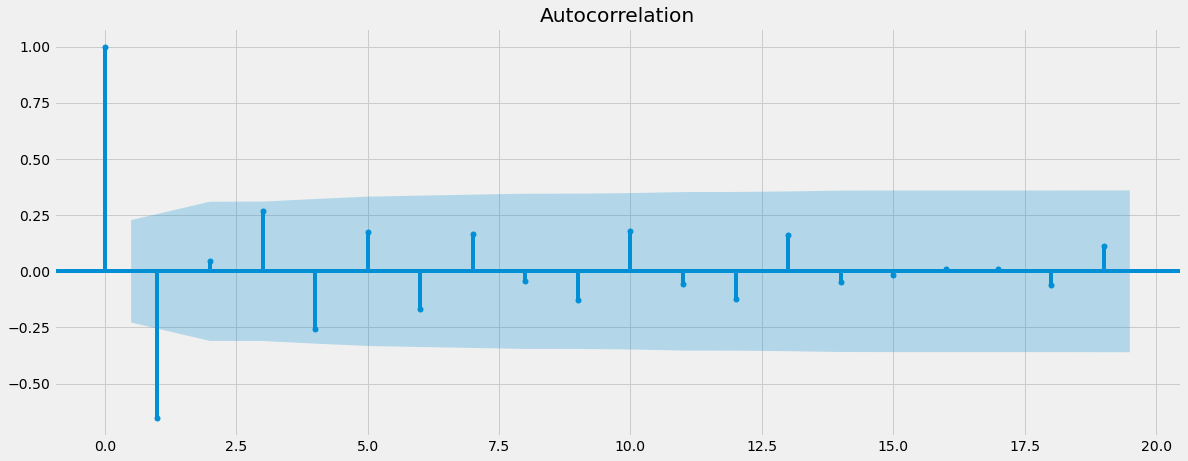

MDMA in Belgium


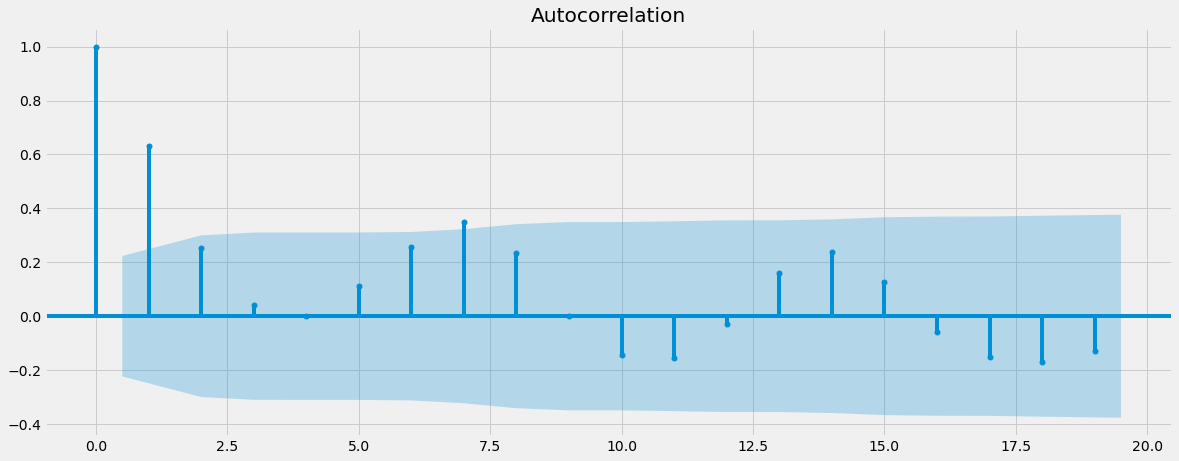

Cocaine in Netherlands


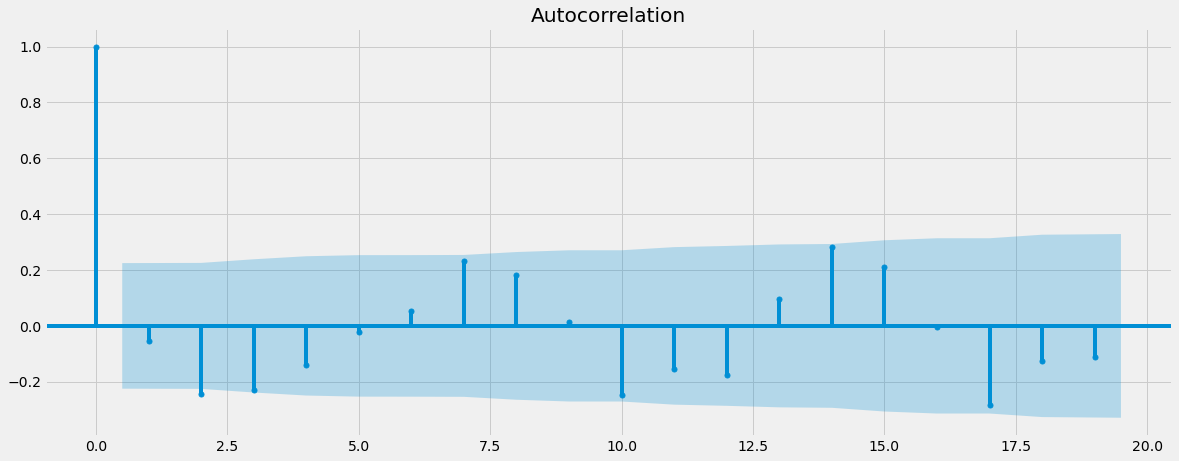

MDMA in Netherlands


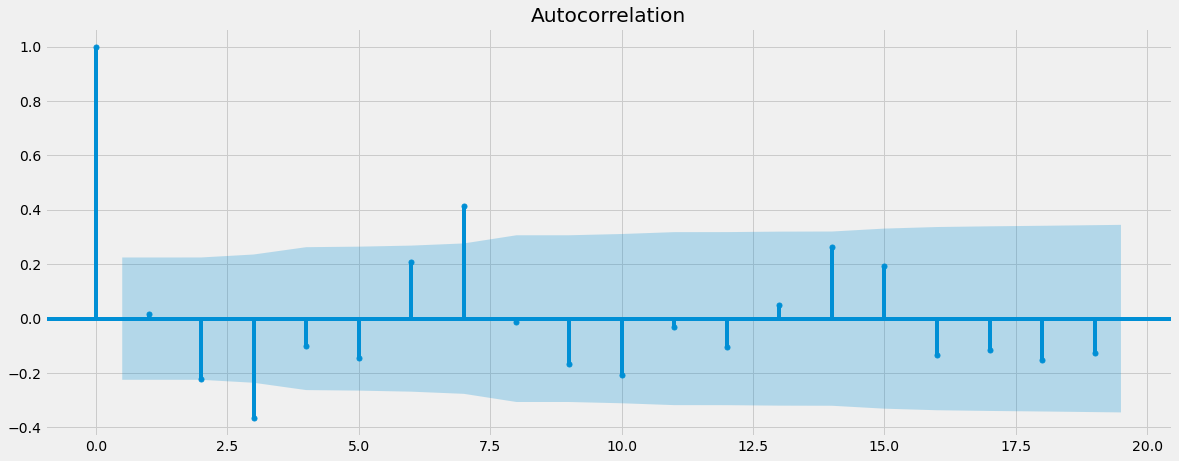

In [52]:
# Creating (again) the Autocorrelation charts to determine q

plt.figure(figsize=(15,5),dpi=300)

print(df_ts_name_list[0])
plot_acf(df_coc_bel);
plt.show();

print(df_ts_name_list[1])
plot_acf(df_mdm_bel);
plt.show();

print(df_ts_name_list[2])
plot_acf(df_coc_net);
plt.show();

print(df_ts_name_list[3])
plot_acf(df_mdm_net);
plt.show();

Looking at the ACF plots, we take the following parameters for q:
<ul>
    <li>
        Cocaine in Belgium: <b>1</b>
    </li>
    <li>
        MDMA in Belgium: <b>1</b>
    </li>
    <li>
        Cocaine in Netherlands: <b>3</b>
    </li>
    <li>
        MDMA in Belgium: <b>3</b>
    </li>
</ul>

<h3>
    Creating the train and test dataframes
</h3>

I will split the data on the last available value of 2019. Therefore, right before the year of the pandemic.

In [139]:
# Splitting, using copies of the original dataframes, in case something goes wrong and then I don't need to rerun the whole
# notebook

df_coc_bel_train = df_coc_bel.copy()
df_coc_bel_test = df_coc_bel.copy()

In [140]:
df_coc_bel_train = df_coc_bel_train['value'][:60]
df_coc_bel_test = df_coc_bel_test['value'][59:]

In [141]:
df_mdm_bel_train = df_mdm_bel.copy()
df_mdm_bel_test = df_mdm_bel.copy()

In [142]:
df_mdm_bel_train = df_mdm_bel_train['value'][:63]
df_mdm_bel_test = df_mdm_bel_test['value'][62:]

In [143]:
df_coc_net_train = df_coc_net.copy()
df_coc_net_test = df_coc_net.copy()

In [144]:
df_coc_net_train = df_coc_net_train['value'][:62]
df_coc_net_test = df_coc_net_test['value'][61:]

In [145]:
df_mdm_net_train = df_mdm_net.copy()
df_mdm_net_test = df_mdm_net.copy()

In [146]:
df_mdm_net_train = df_mdm_net_train['value'][:62]
df_mdm_net_test = df_mdm_net_test['value'][61:]

In [147]:
# Checking the splits

df_coc_bel_train
df_coc_bel_test

time
2011-06-06    -73.610000
2011-07-28     65.135000
2011-09-18   -221.290000
2011-11-09    215.610000
2012-01-01     68.581667
2012-02-22   -147.403333
2012-04-15    191.831667
2012-06-06   -190.796667
2012-07-28     -1.726667
2012-09-18     55.480000
2012-11-09    -19.983333
2013-01-01   -102.615000
2013-02-22    250.068333
2013-04-15   -103.190000
2013-06-06     14.428333
2013-07-28    -65.640000
2013-09-18    -61.135000
2013-11-09     97.461667
2014-01-01      8.822500
2014-02-22     43.823333
2014-04-15    -59.180000
2014-06-06    -38.495000
2014-07-28     57.582500
2014-09-18    -11.290000
2014-11-09   -208.065000
2015-01-01    328.950000
2015-02-22   -126.855000
2015-04-15     13.859286
2015-06-06     -6.362857
2015-07-28     -7.178571
2015-09-18   -108.052857
2015-11-09    135.517143
2016-01-01     76.322286
2016-02-22   -224.840571
2016-04-15    189.265143
2016-06-06    -39.378000
2016-07-28      1.288000
2016-09-18   -329.318000
2016-11-09    405.064000
2017-01-01   -118.83

time
2019-11-09     953.740000
2020-01-01    -769.406000
2020-02-22     275.464000
2020-04-15      13.232000
2020-06-06     -14.380000
2020-07-28     242.770000
2020-09-18   -1004.613333
2020-11-09    1332.923333
2021-01-01    -329.120000
2021-02-22    -649.536667
2021-04-15     569.146667
2021-06-06    -131.540000
2021-07-28    -290.660000
2021-09-18     340.810000
2021-11-09    -303.320000
Name: value, dtype: float64

In [148]:
df_mdm_bel_train
df_mdm_bel_test

time
2011-01-01    16.400000
2011-02-22    15.310000
2011-04-15    18.795000
2011-06-06    45.780000
2011-07-28    56.395000
2011-09-18    32.850000
2011-11-09    21.105000
2012-01-01    23.643333
2012-02-22    17.863333
2012-04-15    22.786667
2012-06-06    40.143333
2012-07-28    50.090000
2012-09-18    39.480000
2012-11-09    33.910000
2013-01-01    18.273333
2013-02-22    13.970000
2013-04-15    14.803333
2013-06-06    23.271667
2013-07-28    44.435000
2013-09-18    32.468333
2013-11-09    18.850000
2014-01-01    18.335000
2014-02-22    15.067500
2014-04-15    27.470000
2014-06-06    25.600000
2014-07-28    37.730000
2014-09-18    41.115000
2014-11-09    21.877500
2015-01-01    17.400000
2015-02-22    24.198571
2015-04-15    17.131429
2015-06-06    20.357143
2015-07-28    40.764286
2015-09-18    29.442857
2015-11-09    20.975714
2016-01-01    31.928000
2016-02-22    25.150000
2016-04-15    26.360000
2016-06-06    46.092000
2016-07-28    68.400000
2016-09-18    47.596000
2016-11-09 

time
2019-11-09    60.662000
2020-01-01    36.143333
2020-02-22    27.583333
2020-04-15    32.946667
2020-06-06    39.720000
2020-07-28    73.666667
2020-09-18    37.310000
2020-11-09    45.970000
2021-01-01    38.740000
2021-02-22    35.550000
2021-04-15    38.845000
2021-06-06    66.795000
2021-07-28    92.210000
2021-09-18    98.300000
2021-11-09    40.990000
Name: value, dtype: float64

In [149]:
df_coc_net_train
df_coc_net_test

time
2011-02-22    -12.226667
2011-04-15    108.056667
2011-06-06     38.176667
2011-07-28    -58.276667
2011-09-18   -271.523333
2011-11-09      4.806667
2012-01-01    175.776667
2012-02-22    -58.593333
2012-04-15    102.906667
2012-06-06     67.366667
2012-07-28     88.143333
2012-09-18   -243.580000
2012-11-09     16.213333
2013-01-01   -151.043333
2013-02-22     77.440000
2013-04-15    180.613333
2013-06-06    -26.963333
2013-07-28   -116.933333
2013-09-18    -78.540000
2013-11-09    -37.330000
2014-01-01     58.370000
2014-02-22    109.970000
2014-04-15    -24.560000
2014-06-06    102.933333
2014-07-28     31.083333
2014-09-18    -54.463333
2014-11-09    -45.153333
2015-01-01   -184.786667
2015-02-22     60.990000
2015-04-15    119.793333
2015-06-06    165.043333
2015-07-28    -33.640000
2015-09-18   -303.096667
2015-11-09     74.466667
2016-01-01     13.868333
2016-02-22     11.240000
2016-04-15     16.050000
2016-06-06    155.425000
2016-07-28     20.075000
2016-09-18   -113.56

time
2019-11-09     37.533333
2020-01-01   -174.910000
2020-02-22     14.003333
2020-04-15    117.790000
2020-06-06      7.140000
2020-07-28     58.580000
2020-09-18   -130.833333
2020-11-09    -43.226667
2021-01-01    127.280000
2021-02-22   -100.723333
2021-04-15     39.510000
2021-06-06    125.440000
2021-07-28    159.313333
2021-09-18   -214.303333
2021-11-09    -32.603333
Name: value, dtype: float64

In [150]:
df_mdm_net_train
df_mdm_net_test

time
2011-02-22    -35.330000
2011-04-15     -2.835000
2011-06-06      4.870000
2011-07-28     60.230000
2011-09-18    -87.175000
2011-11-09     -5.385000
2012-01-01     40.075000
2012-02-22     -3.565000
2012-04-15     16.075000
2012-06-06     73.920000
2012-07-28    147.880000
2012-09-18   -153.415000
2012-11-09    -28.875000
2013-01-01    -61.250000
2013-02-22      1.050000
2013-04-15      0.820000
2013-06-06     68.930000
2013-07-28    -22.930000
2013-09-18      9.470000
2013-11-09    -21.730000
2014-01-01     -5.690000
2014-02-22     -8.820000
2014-04-15     -2.510000
2014-06-06     10.835000
2014-07-28     87.380000
2014-09-18      1.005000
2014-11-09    -12.495000
2015-01-01    -50.150000
2015-02-22    -66.980000
2015-04-15     26.920000
2015-06-06     56.553333
2015-07-28    126.590000
2015-09-18   -117.556667
2015-11-09    -40.303333
2016-01-01    -18.523333
2016-02-22     -5.520000
2016-04-15    -28.160000
2016-06-06     80.190000
2016-07-28     72.950000
2016-09-18    -50.96

time
2019-11-09   -28.293333
2020-01-01   -62.556667
2020-02-22   -19.030000
2020-04-15    40.666667
2020-06-06    -0.820000
2020-07-28    42.343333
2020-09-18   -32.490000
2020-11-09   -30.400000
2021-01-01   -39.630000
2021-02-22    -2.456667
2021-04-15    -1.666667
2021-06-06    54.813333
2021-07-28    77.166667
2021-09-18   -63.503333
2021-11-09   -49.900000
Name: value, dtype: float64

<Figure size 4500x1500 with 0 Axes>

Cocaine in Belgium


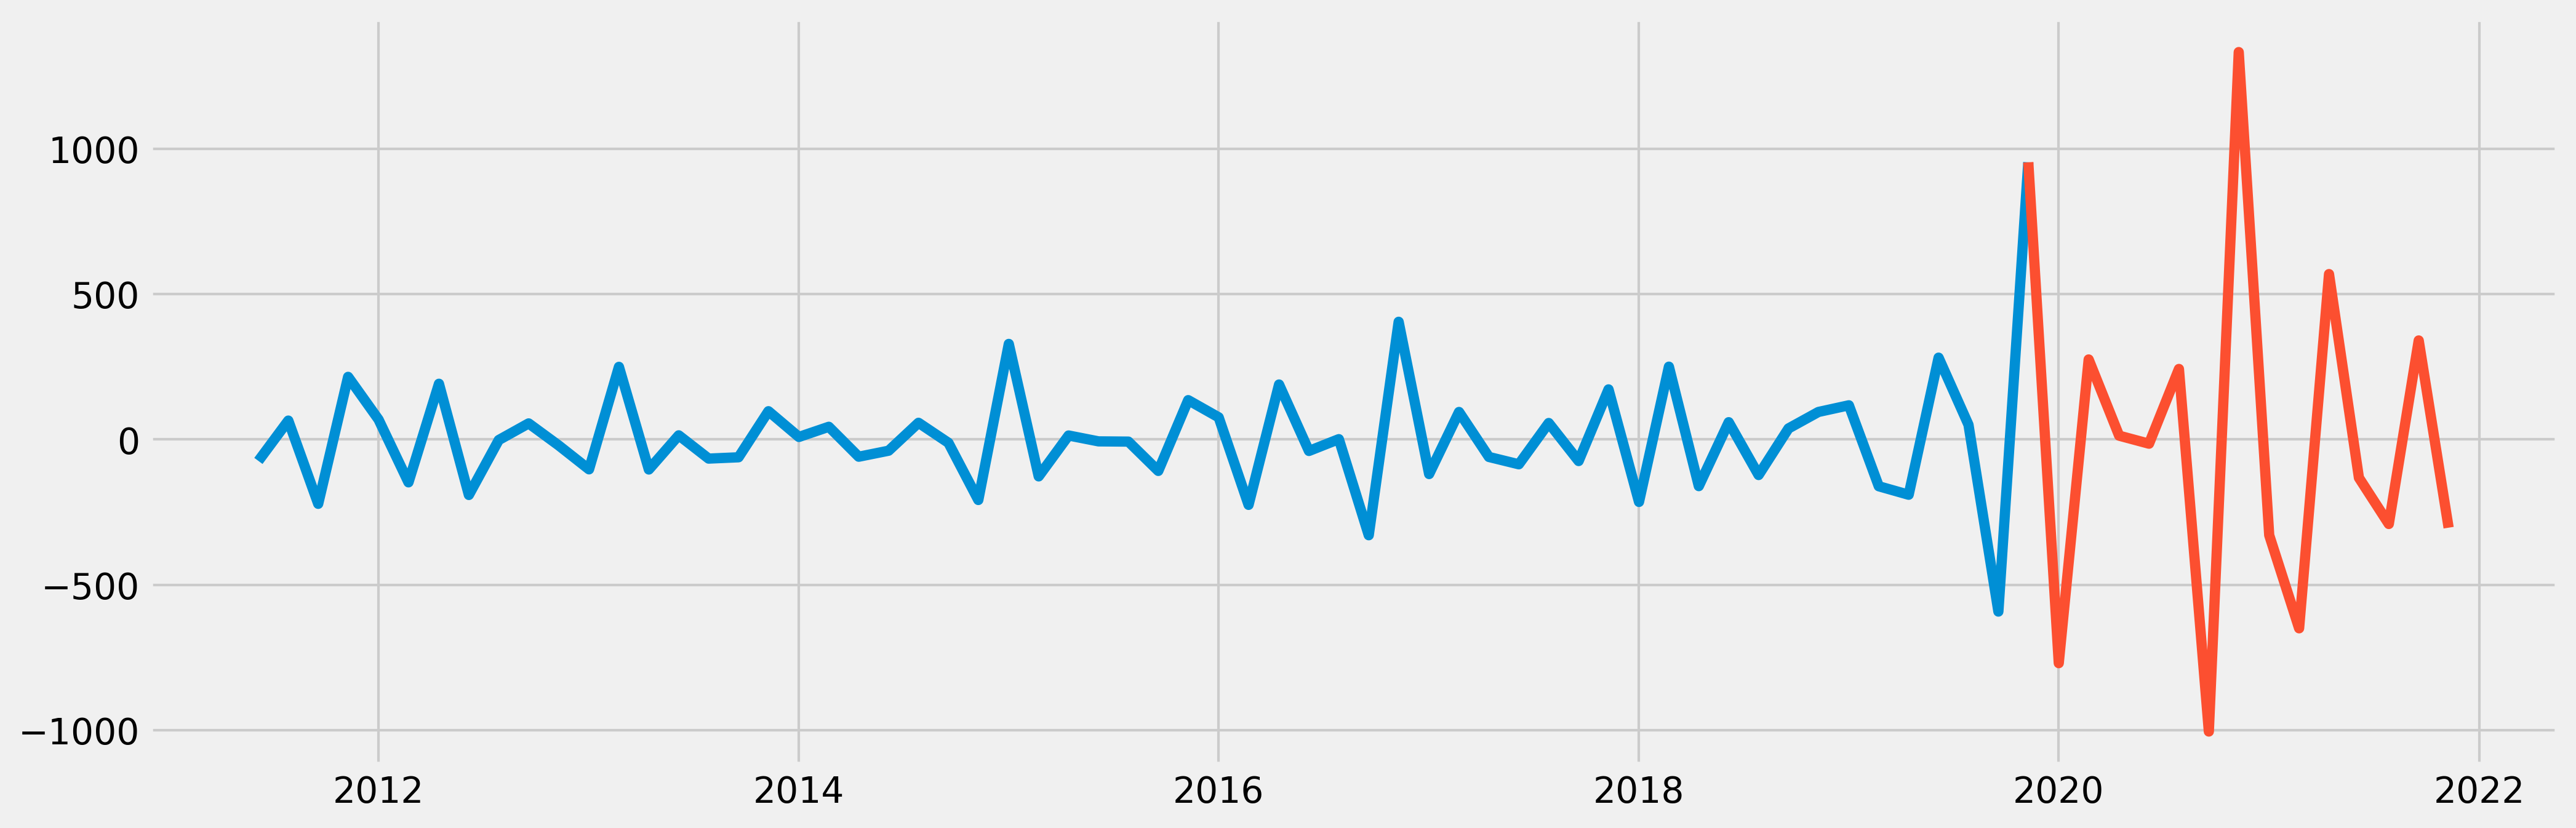

MDMA in Belgium


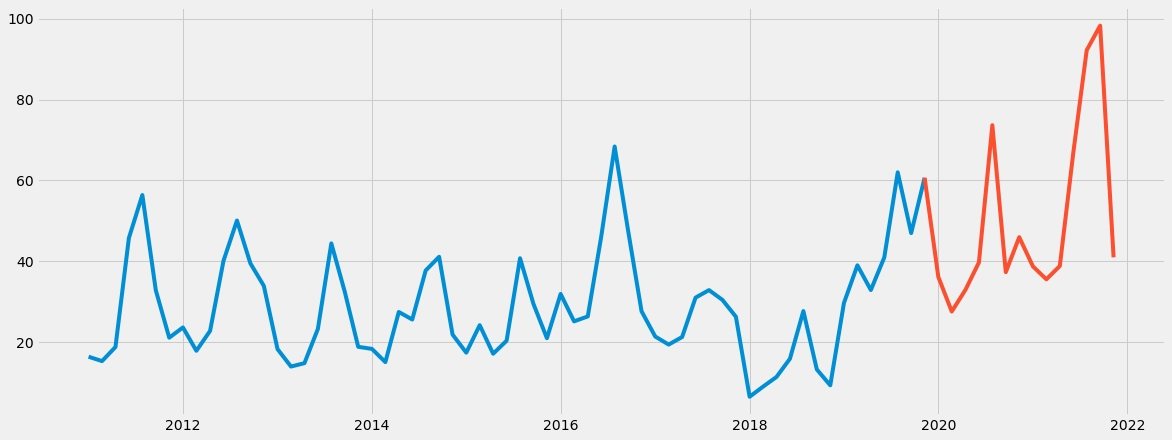

Cocaine in Netherlands


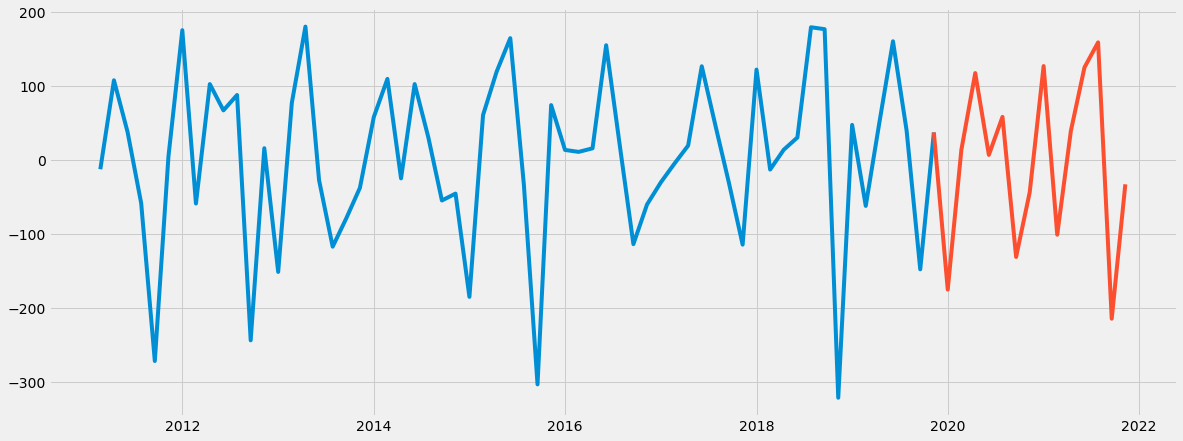

MDMA in Netherlands


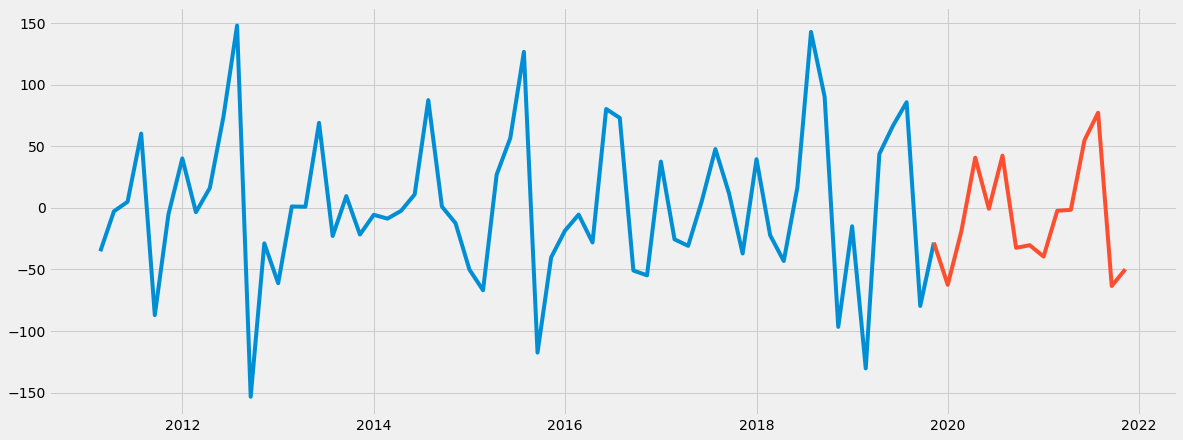

In [155]:
# Visualizing the splittet data:

dfs_train = [df_coc_bel_train, df_mdm_bel_train, df_coc_net_train, df_mdm_net_train]
dfs_test = [df_coc_bel_test, df_mdm_bel_test, df_coc_net_test, df_mdm_net_test]


plt.figure(figsize=(15,5), dpi=300);

for i in range(0,4):
    print(df_ts_name_list[i]);
    output_plot = (plt.plot(dfs_train[i]),plt.plot(dfs_test[i])); 
    plt.show();

<h3>
    Time Series Forecast - Cocaine in Belgium
</h3>

In [356]:
# Ingoring warnings

import warnings
warnings.filterwarnings("ignore")

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   58
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -374.834
Method:                       css-mle   S.D. of innovations            134.699
Date:                Wed, 24 Aug 2022   AIC                            761.668
Time:                        21:24:27   BIC                            774.031
Sample:                             2   HQIC                           766.484
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0061      0.101      0.060      0.952      -0.191       0.204
ar.L1.D2.value    -1.0925      0.123     -8.862      0.000      -1.334      -0.851
ar.L2.D2.value    -0.6087      0.133

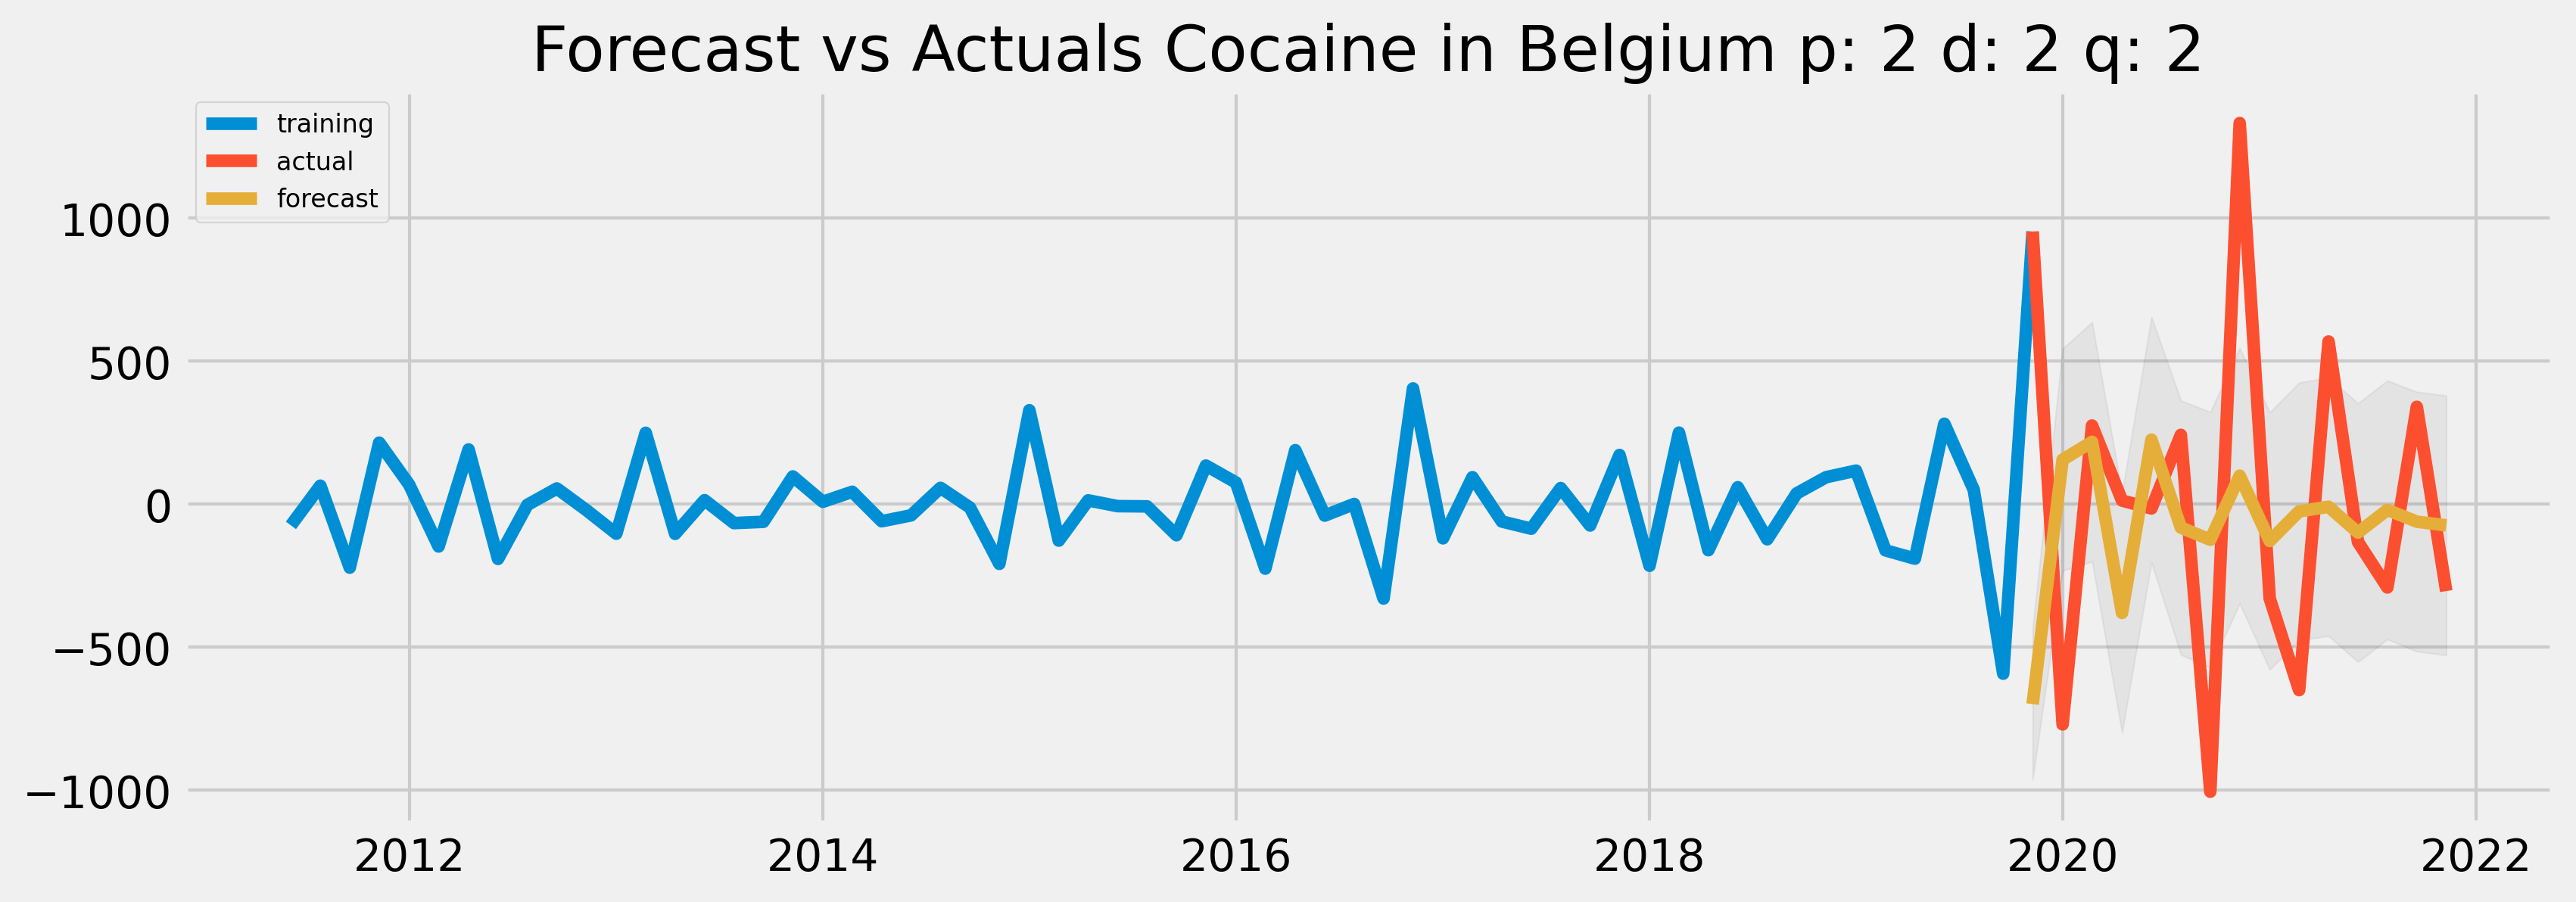

In [413]:
hit = 0
p = 2
d = 2
q = 2

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[0]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[0]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   58
Model:                 ARIMA(3, 2, 3)   Log Likelihood                -389.406
Method:                       css-mle   S.D. of innovations            177.459
Date:                Wed, 24 Aug 2022   AIC                            794.812
Time:                        21:24:27   BIC                            811.296
Sample:                             2   HQIC                           801.233
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2103      0.638      0.330      0.742      -1.040       1.461
ar.L1.D2.value    -0.7232      0.131     -5.535      0.000      -0.979      -0.467
ar.L2.D2.value    -0.7612      0.120

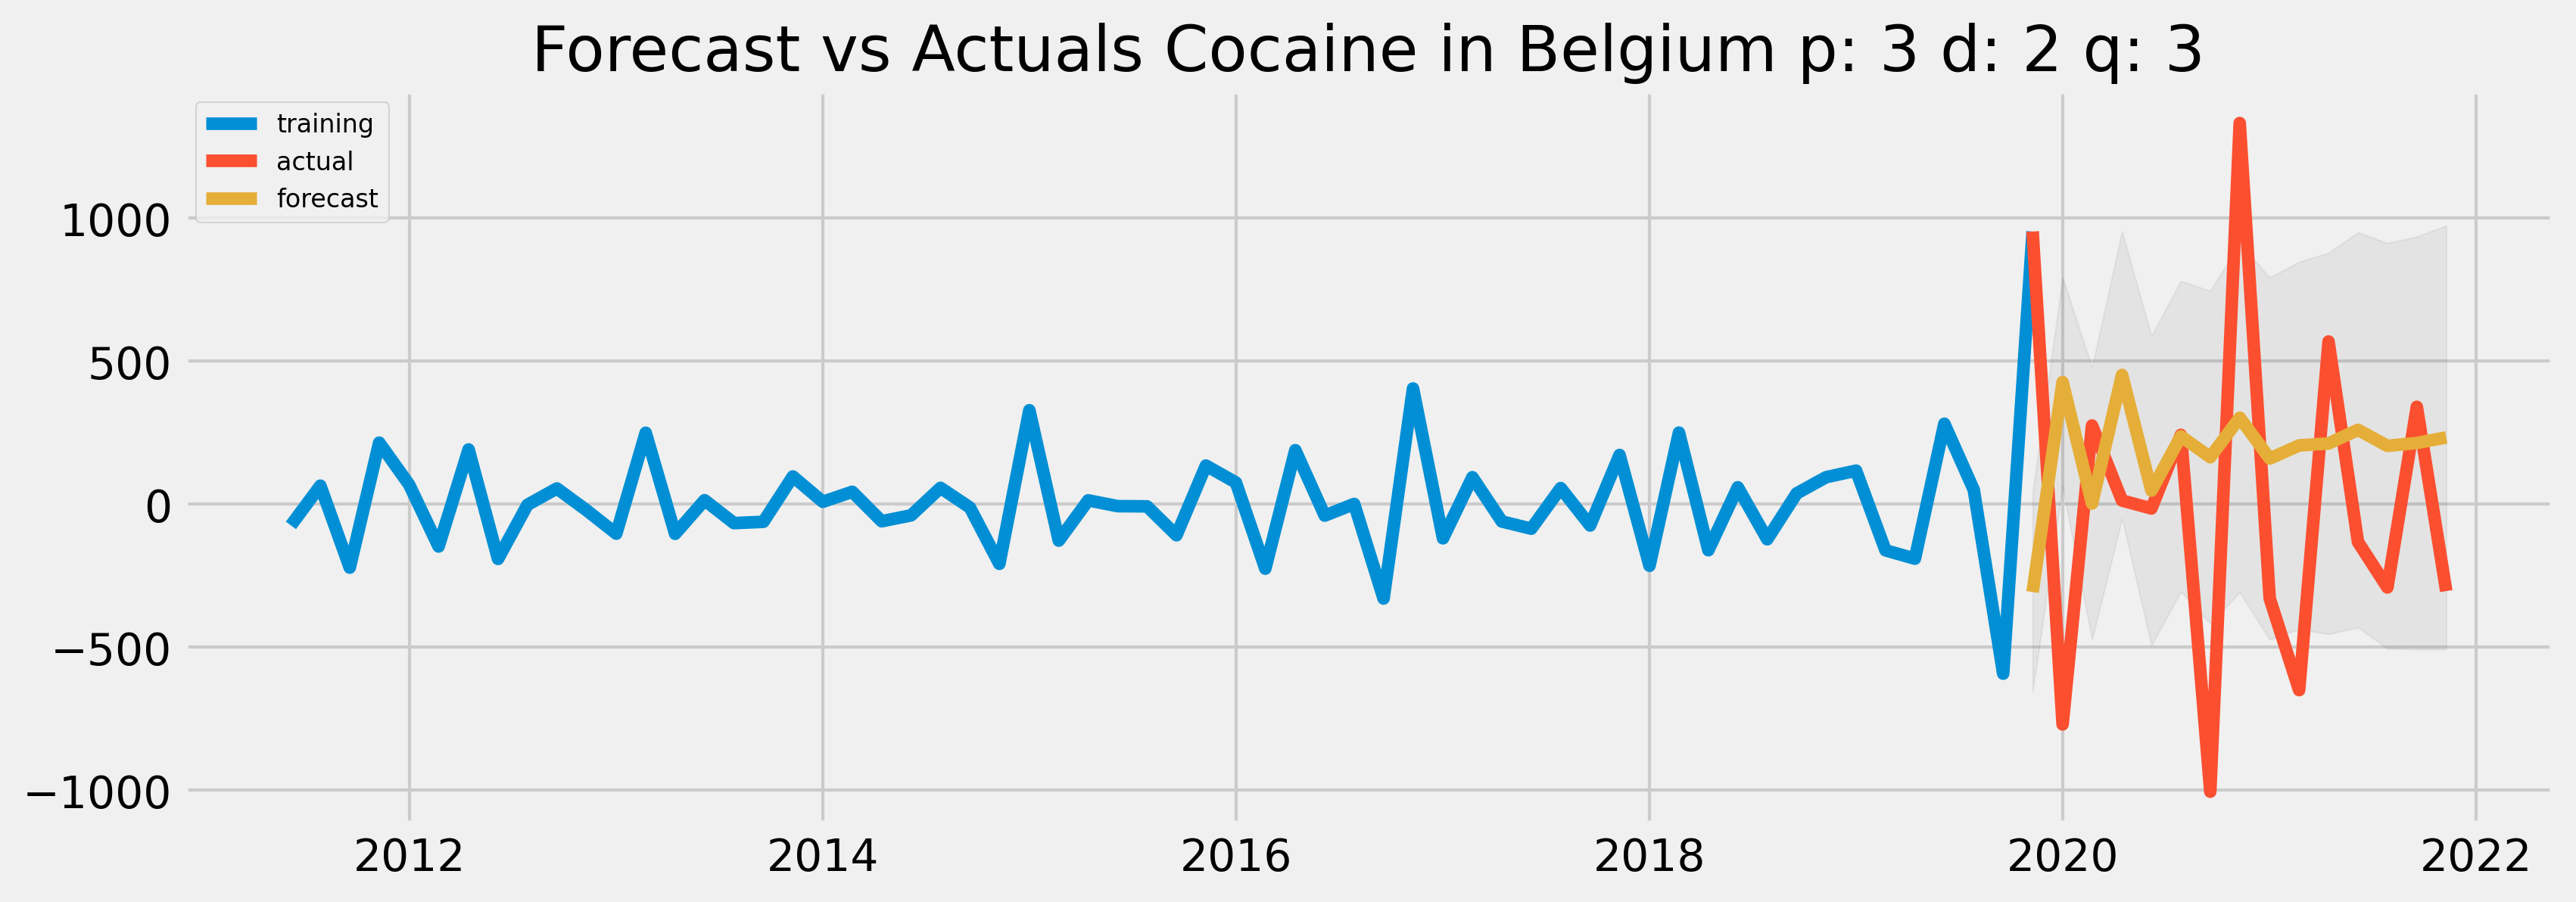

In [414]:
hit = 0
p = 3
d = 2
q = 3

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[0]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[0]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   58
Model:                 ARIMA(5, 2, 3)   Log Likelihood                -647.210
Method:                       css-mle   S.D. of innovations                nan
Date:                Wed, 24 Aug 2022   AIC                           1314.421
Time:                        21:24:30   BIC                           1335.025
Sample:                             2   HQIC                          1322.446
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             23.5361        nan        nan        nan         nan         nan
ar.L1.D2.value    -0.5089   9.63e-06  -5.28e+04      0.000      -0.509      -0.509
ar.L2.D2.value     0.2177   8.78e-06

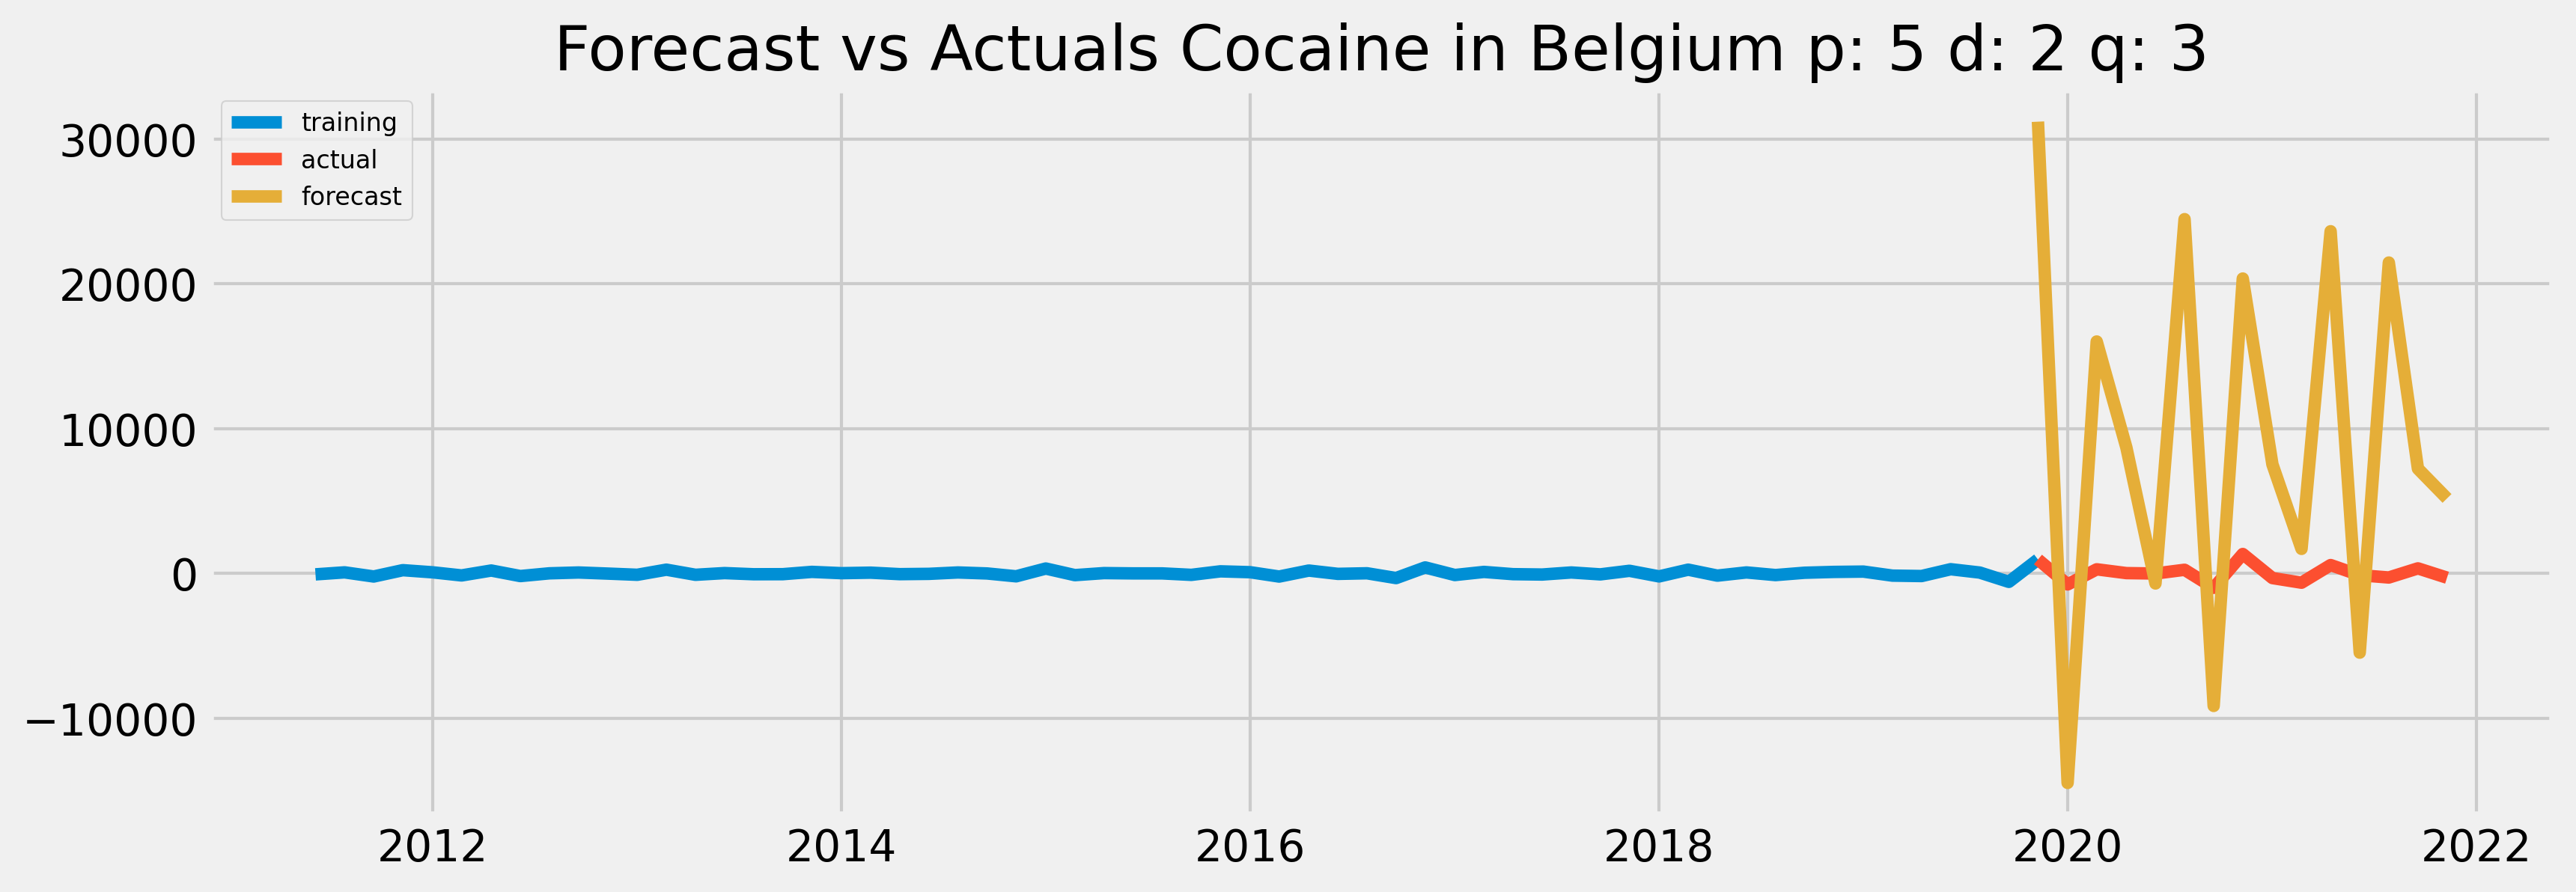

In [415]:
hit = 0
p = 5
d = 2
q = 3

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[0]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[0]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

<h3>
    Time Series Forecast - MDMA in Belgium
</h3>
<p>
    <font color = FF0000>
    <b>Instead of the ARIMA model, we're going to use the ARMA model, since we didn't need any correction rounds.</b>
    </font>

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   63
Model:                     ARMA(1, 1)   Log Likelihood                -234.819
Method:                       css-mle   S.D. of innovations              9.962
Date:                Wed, 24 Aug 2022   AIC                            477.638
Time:                        21:35:53   BIC                            486.211
Sample:                             0   HQIC                           481.010
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          29.3303      2.821     10.398      0.000      23.802      34.859
ar.L1.value     0.2272      0.161      1.414      0.157      -0.088       0.542
ma.L1.value     0.7547      0.125      6.015    

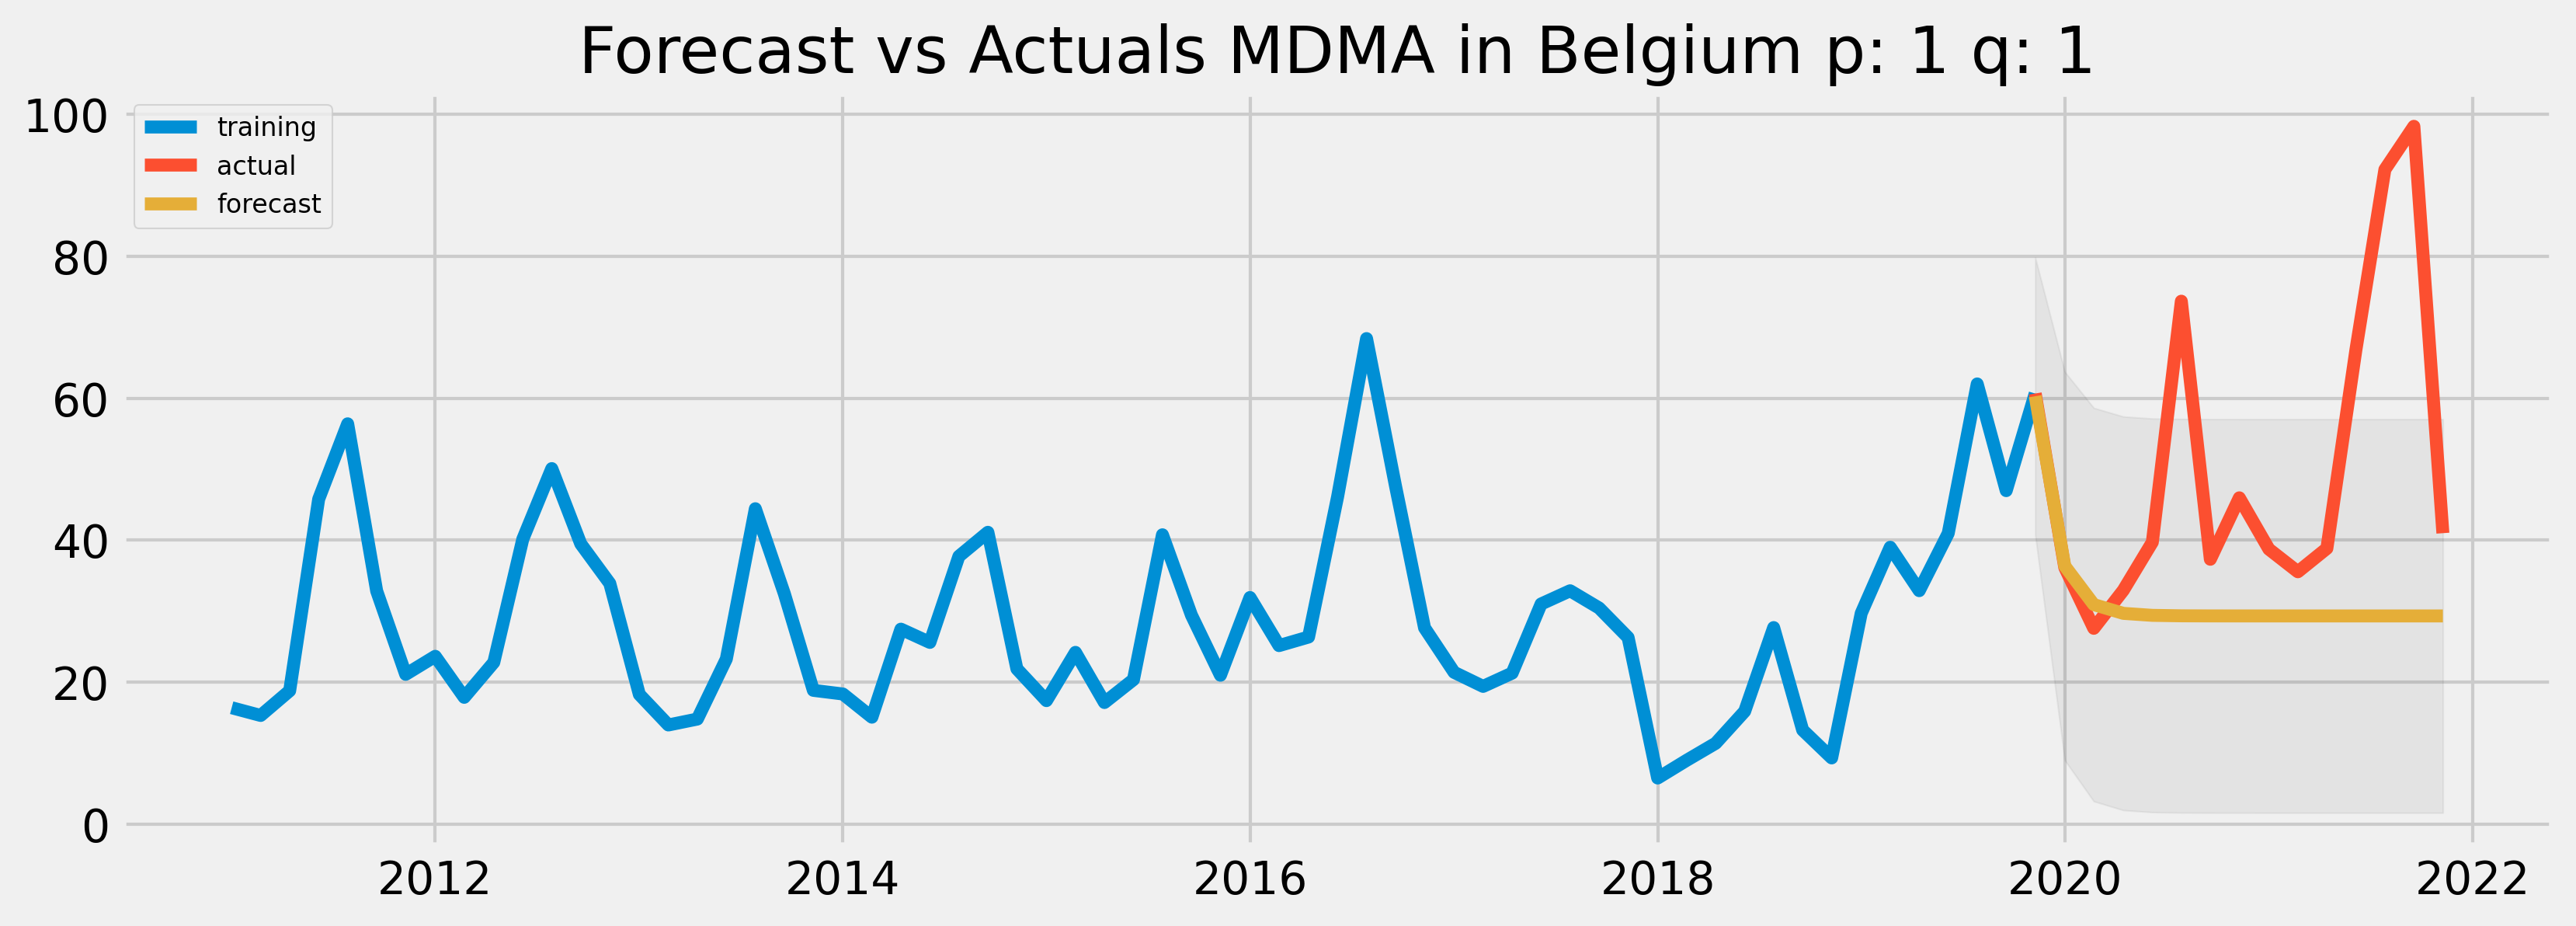

In [426]:
hit = 1
p = 1
q = 1
d = 0

model = ARMA(dfs_train[hit],order=(p,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[1]+' p: '+str(p)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[1]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   63
Model:                     ARMA(2, 2)   Log Likelihood                -234.669
Method:                       css-mle   S.D. of innovations              9.937
Date:                Wed, 24 Aug 2022   AIC                            481.338
Time:                        21:35:54   BIC                            494.197
Sample:                             0   HQIC                           486.396
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          29.3689      3.000      9.788      0.000      23.488      35.250
ar.L1.value     0.0579      0.850      0.068      0.946      -1.609       1.725
ar.L2.value     0.1169      0.239      0.490    

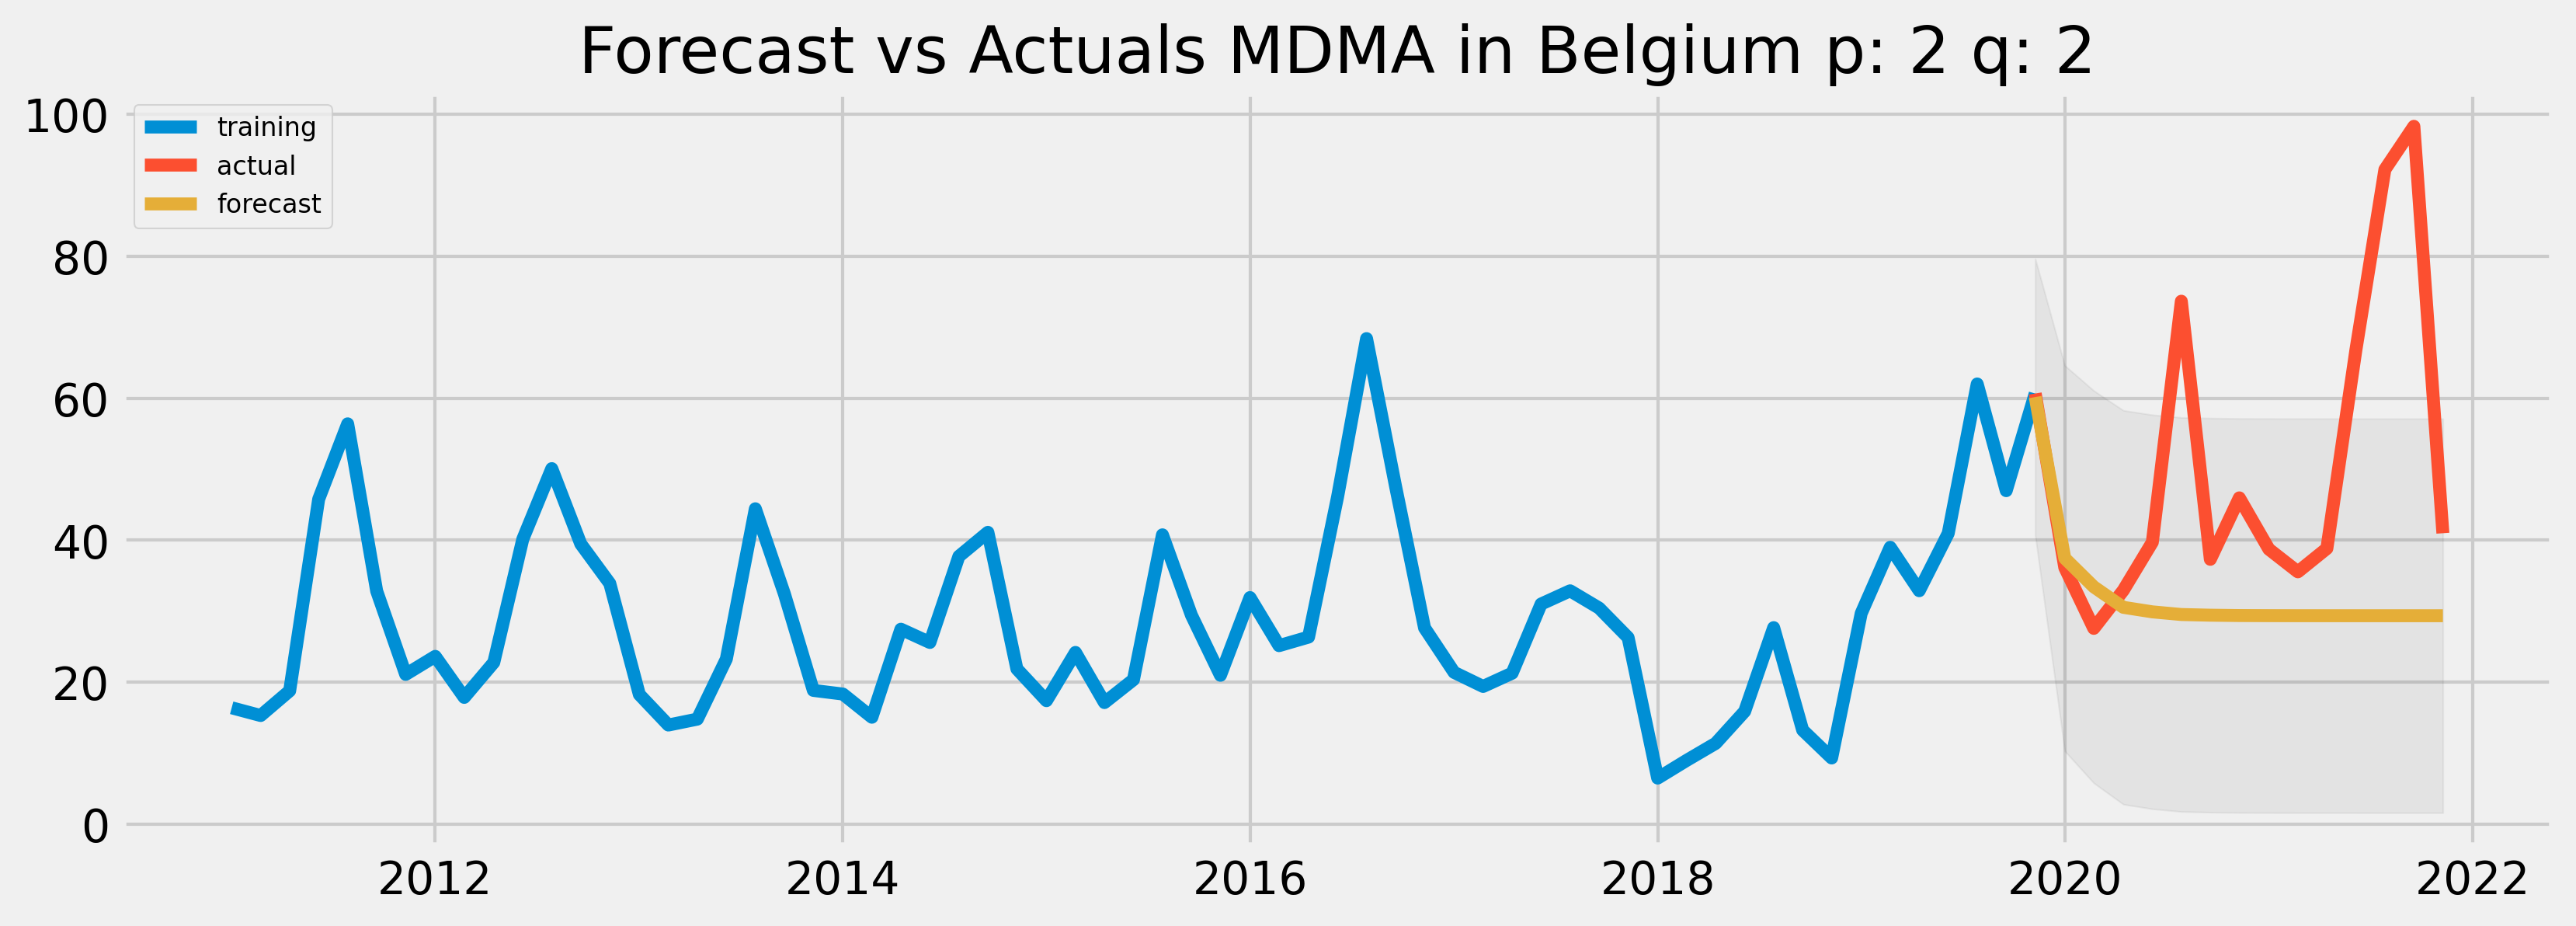

In [427]:
hit = 1
p = 2
q = 2
d = 0

model = ARMA(dfs_train[hit],order=(p,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[1]+' p: '+str(p)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[1]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   63
Model:                     ARMA(7, 3)   Log Likelihood                -225.744
Method:                       css-mle   S.D. of innovations              8.130
Date:                Wed, 24 Aug 2022   AIC                            475.489
Time:                        21:35:58   BIC                            501.207
Sample:                             0   HQIC                           485.604
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          29.3867      2.716     10.820      0.000      24.064      34.710
ar.L1.value     1.1059      0.136      8.140      0.000       0.840       1.372
ar.L2.value    -0.3181      0.193     -1.647    

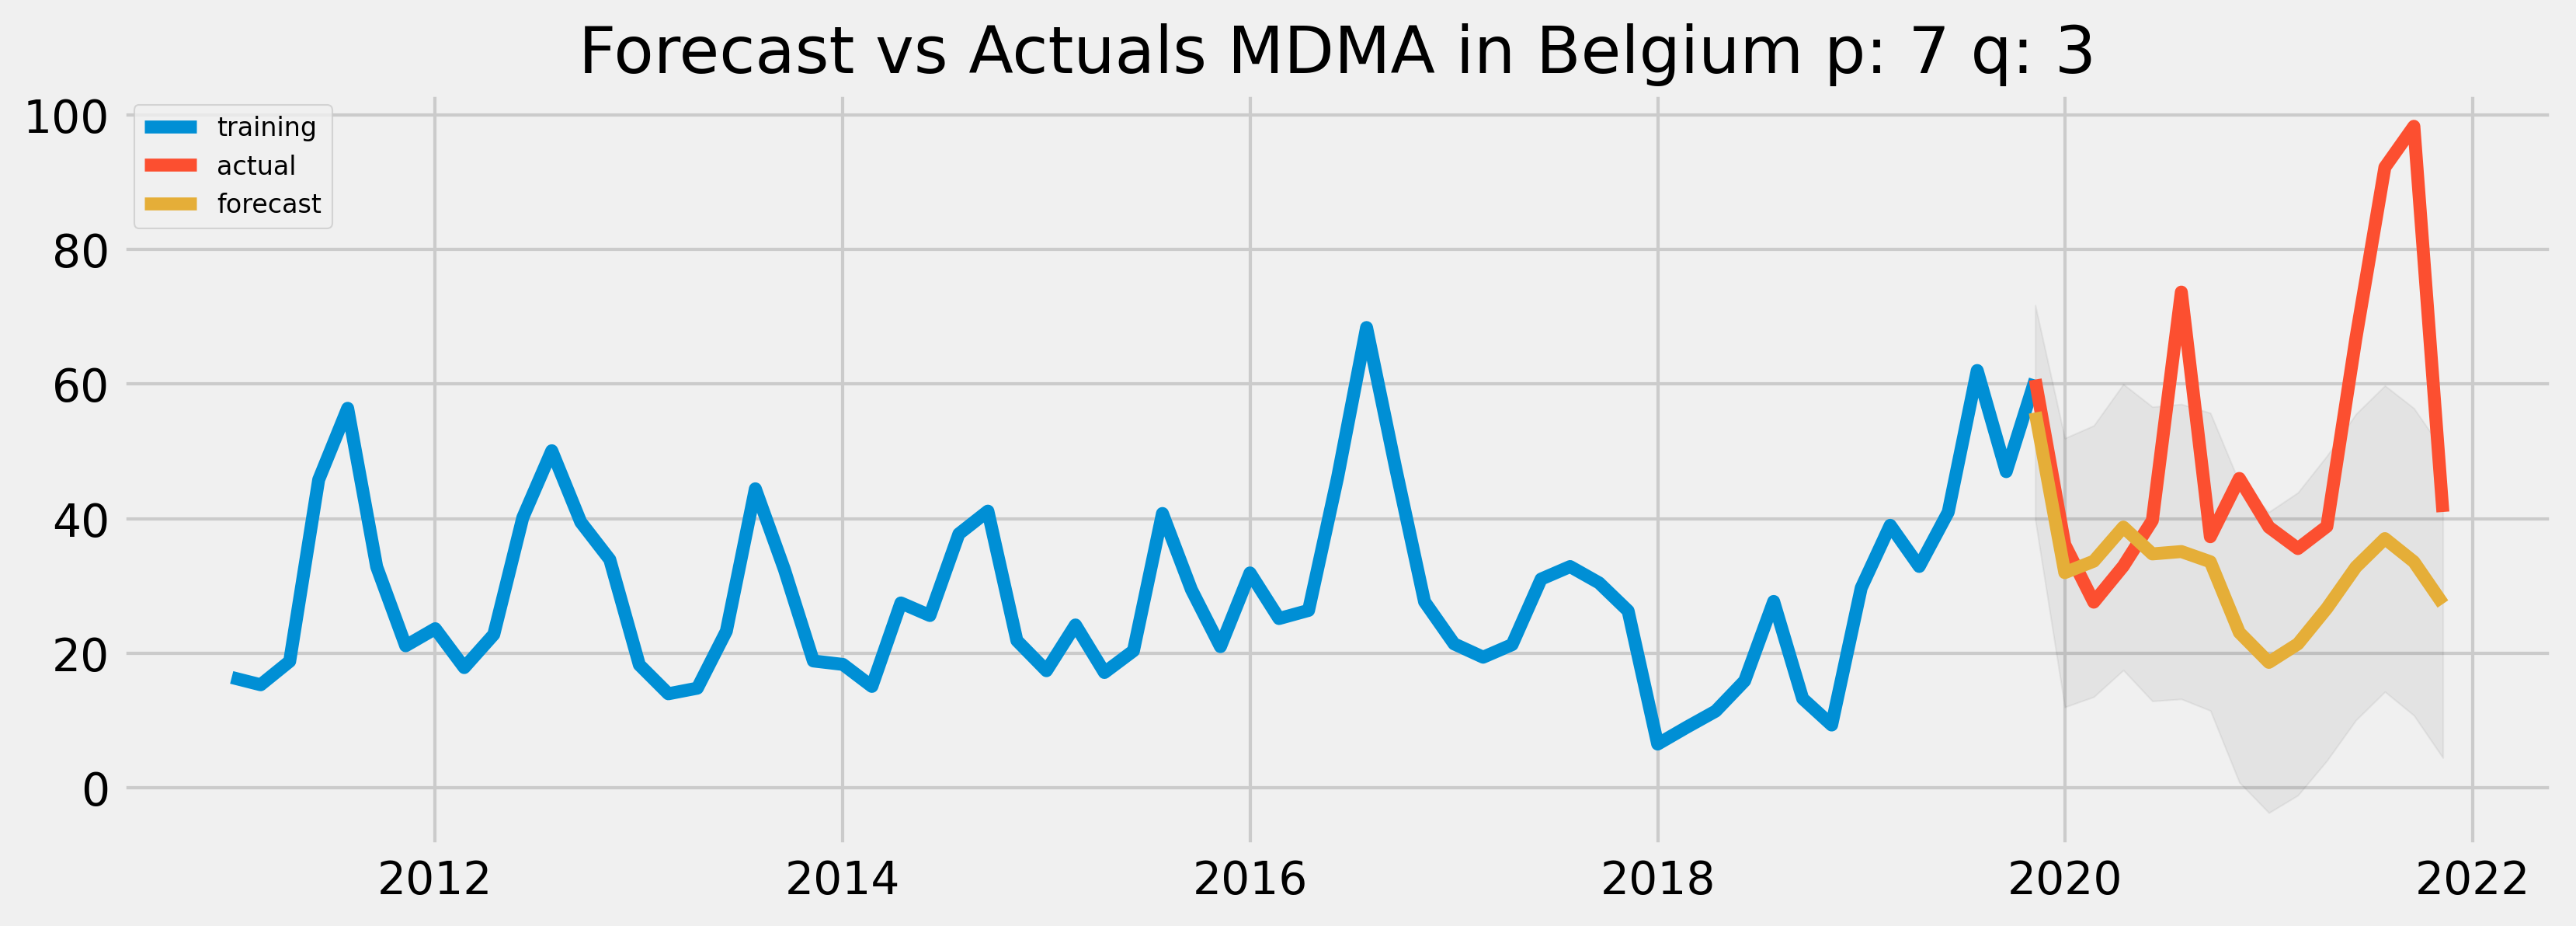

In [428]:
hit = 1
p = 7
q = 3
d = 0

model = ARMA(dfs_train[hit],order=(p,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[1]+' p: '+str(p)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[1]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

<h3>
    Time Series Forecast - Cocaine in Netherlands
</h3>

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   61
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -363.349
Method:                       css-mle   S.D. of innovations             84.942
Date:                Wed, 24 Aug 2022   AIC                            748.697
Time:                        21:24:38   BIC                            771.917
Sample:                             1   HQIC                           757.797
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4432      0.149      2.968      0.003       0.151       0.736
ar.L1.D.value    -0.8124      0.205     -3.967      0.000      -1.214      -0.411
ar.L2.D.value    -0.3062      0.259     

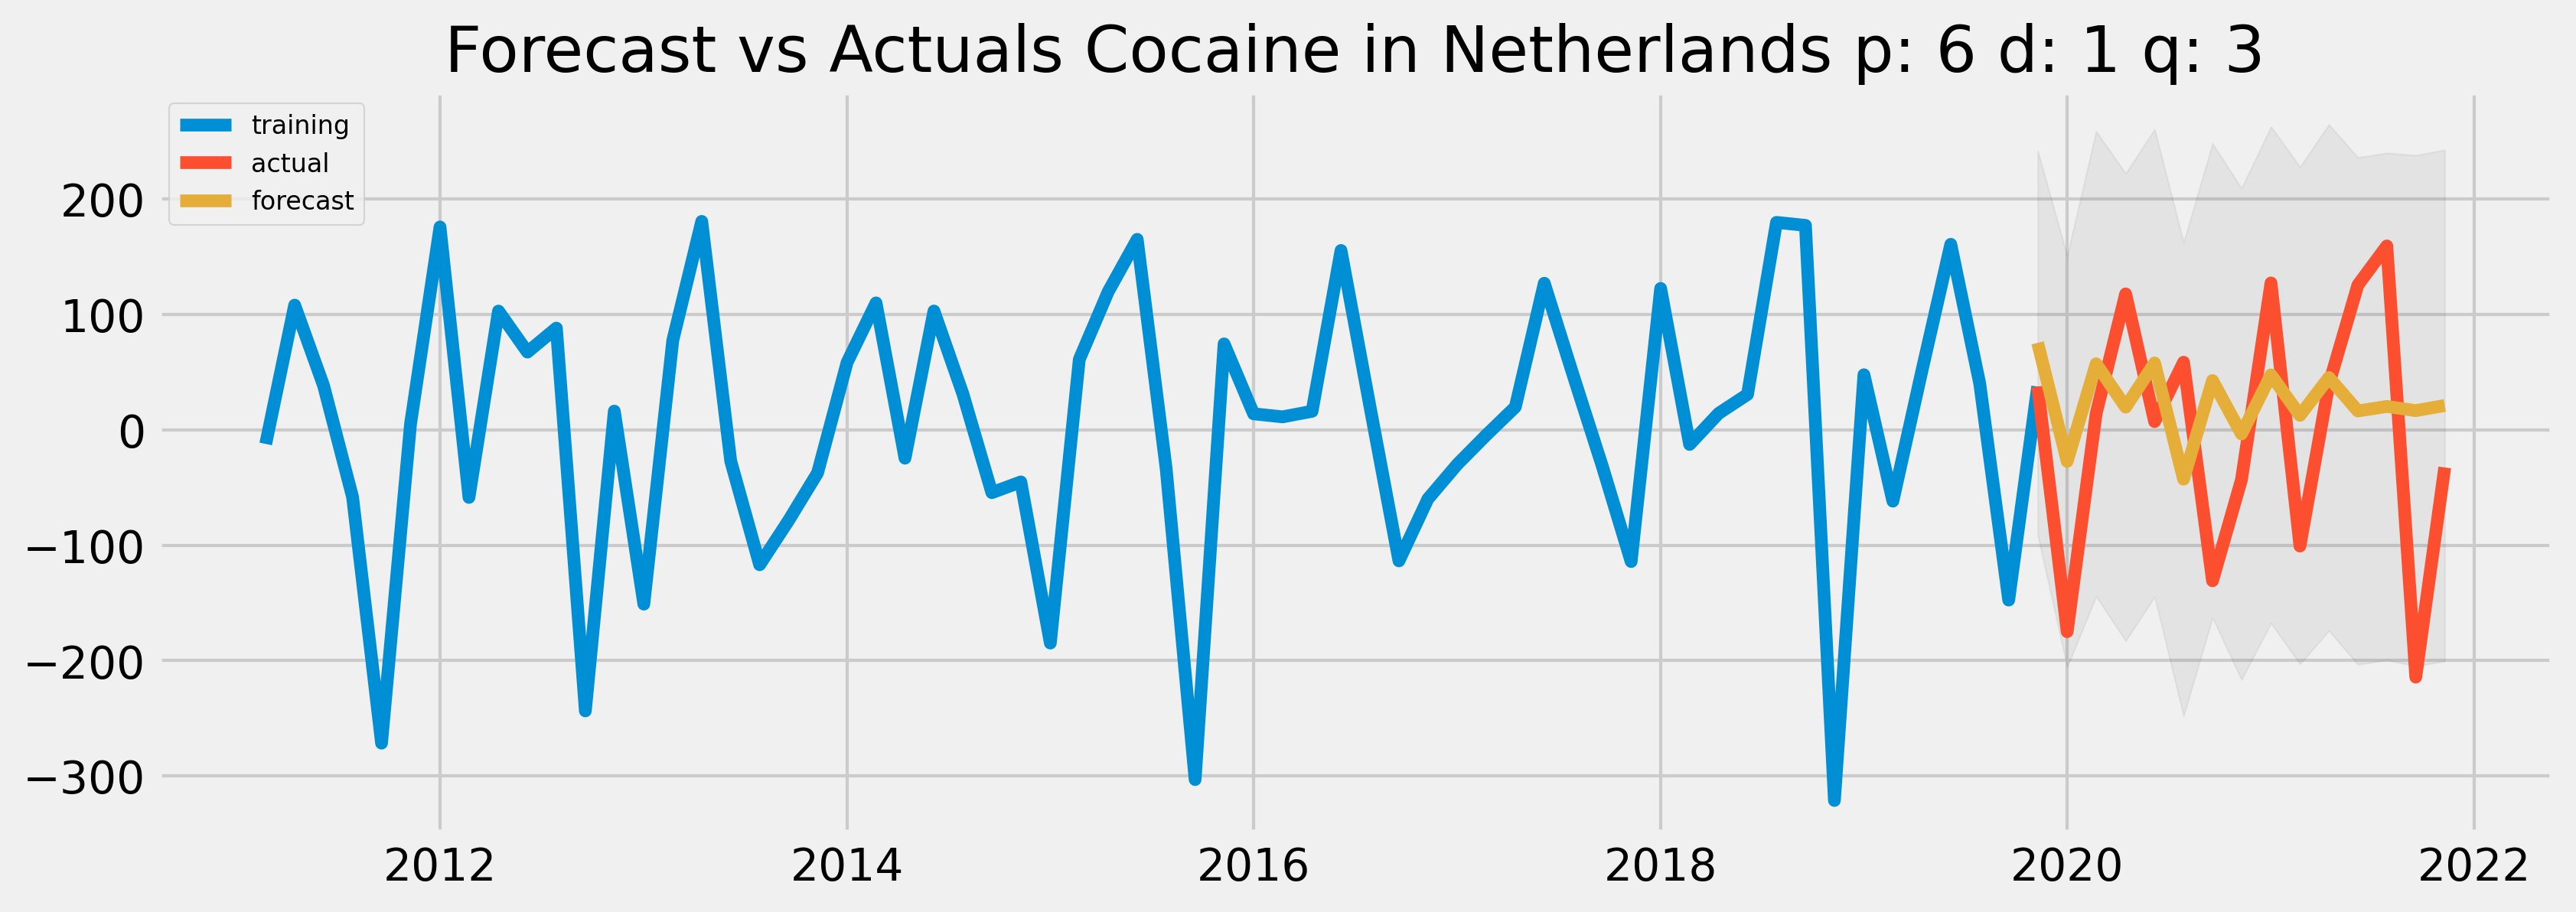

In [419]:
hit = 2
p = 6
d = 1
q = 3

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[2]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[2]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   61
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -358.415
Method:                       css-mle   S.D. of innovations             77.393
Date:                Wed, 24 Aug 2022   AIC                            736.831
Time:                        21:24:41   BIC                            757.939
Sample:                             1   HQIC                           745.103
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3960      0.216      1.831      0.067      -0.028       0.820
ar.L1.D.value     0.7129      0.139      5.137      0.000       0.441       0.985
ar.L2.D.value    -0.7859      0.155     

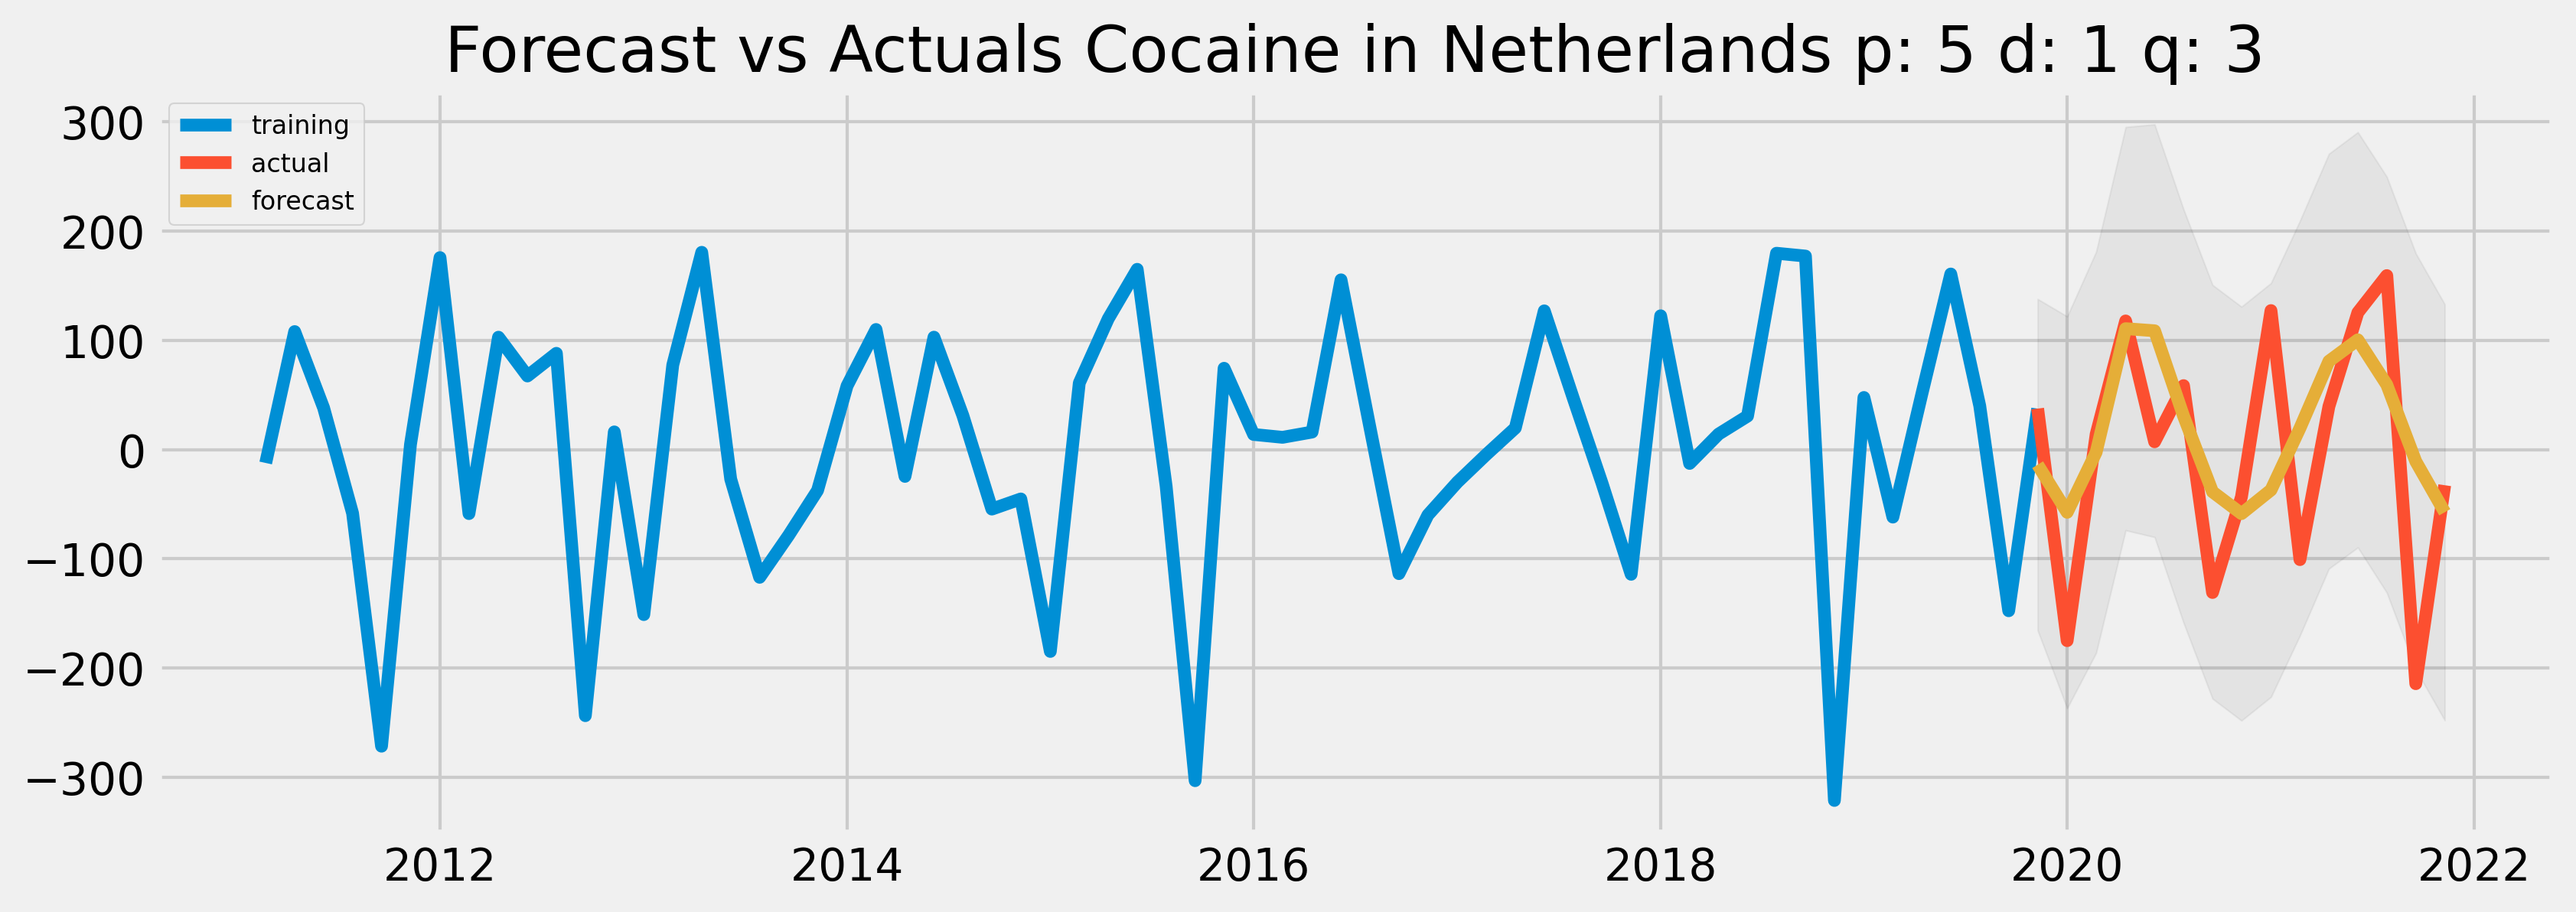

In [420]:
hit = 2
p = 5
d = 1
q = 3

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[2]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[2]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   61
Model:                 ARIMA(7, 1, 3)   Log Likelihood                -363.278
Method:                       css-mle   S.D. of innovations             85.030
Date:                Wed, 24 Aug 2022   AIC                            750.555
Time:                        21:24:42   BIC                            775.886
Sample:                             1   HQIC                           760.482
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4383      0.154      2.837      0.005       0.135       0.741
ar.L1.D.value    -0.9350      0.345     -2.713      0.007      -1.611      -0.259
ar.L2.D.value    -0.4584      0.430     

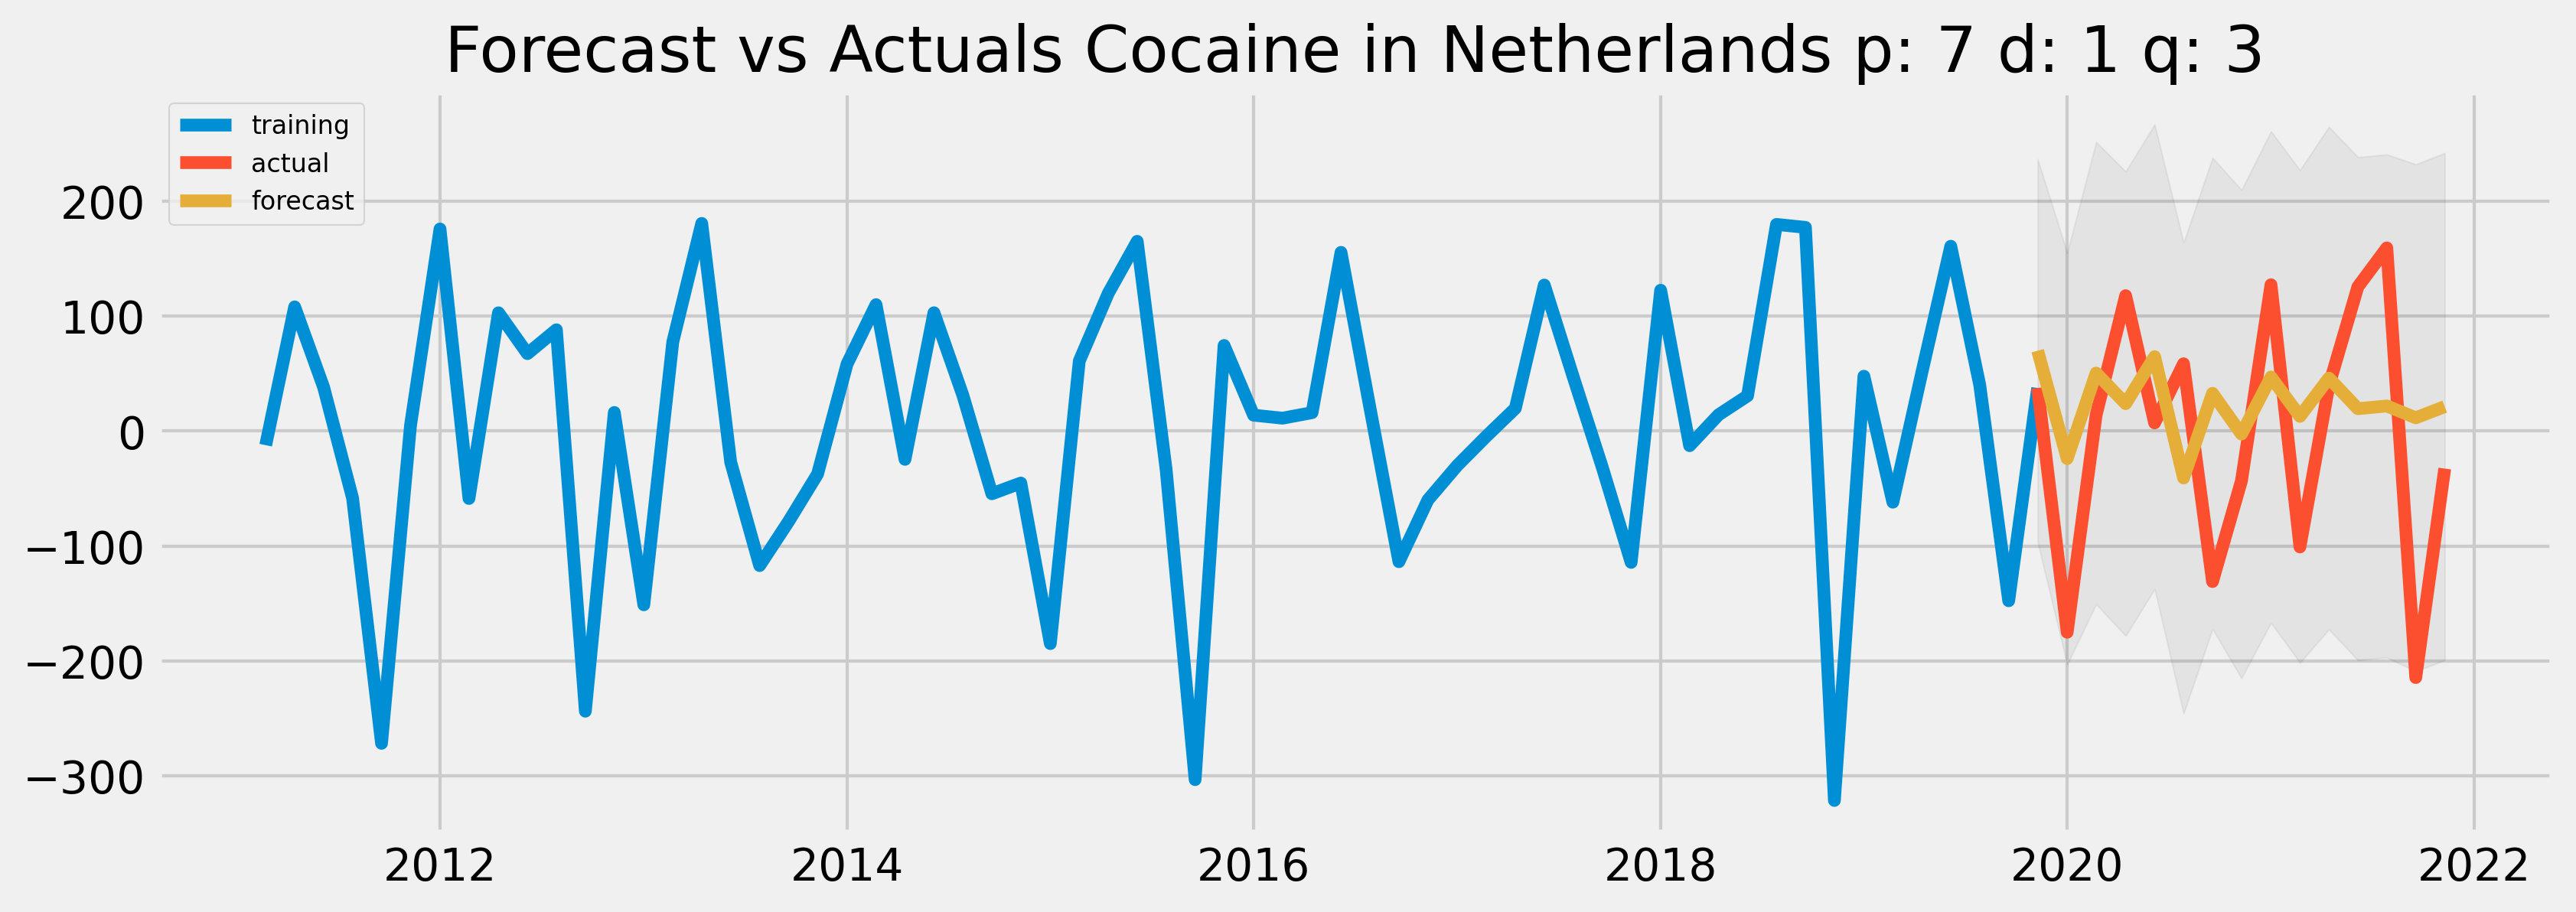

In [421]:
hit = 2
p = 7
d = 1
q = 3

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[2]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[2]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   61
Model:                 ARIMA(8, 1, 3)   Log Likelihood                -359.198
Method:                       css-mle   S.D. of innovations             76.563
Date:                Wed, 24 Aug 2022   AIC                            744.395
Time:                        21:24:57   BIC                            771.837
Sample:                             1   HQIC                           755.150
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2602      1.426      0.182      0.855      -2.535       3.055
ar.L1.D.value    -1.0441      0.124     -8.442      0.000      -1.287      -0.802
ar.L2.D.value    -0.9572      0.173     

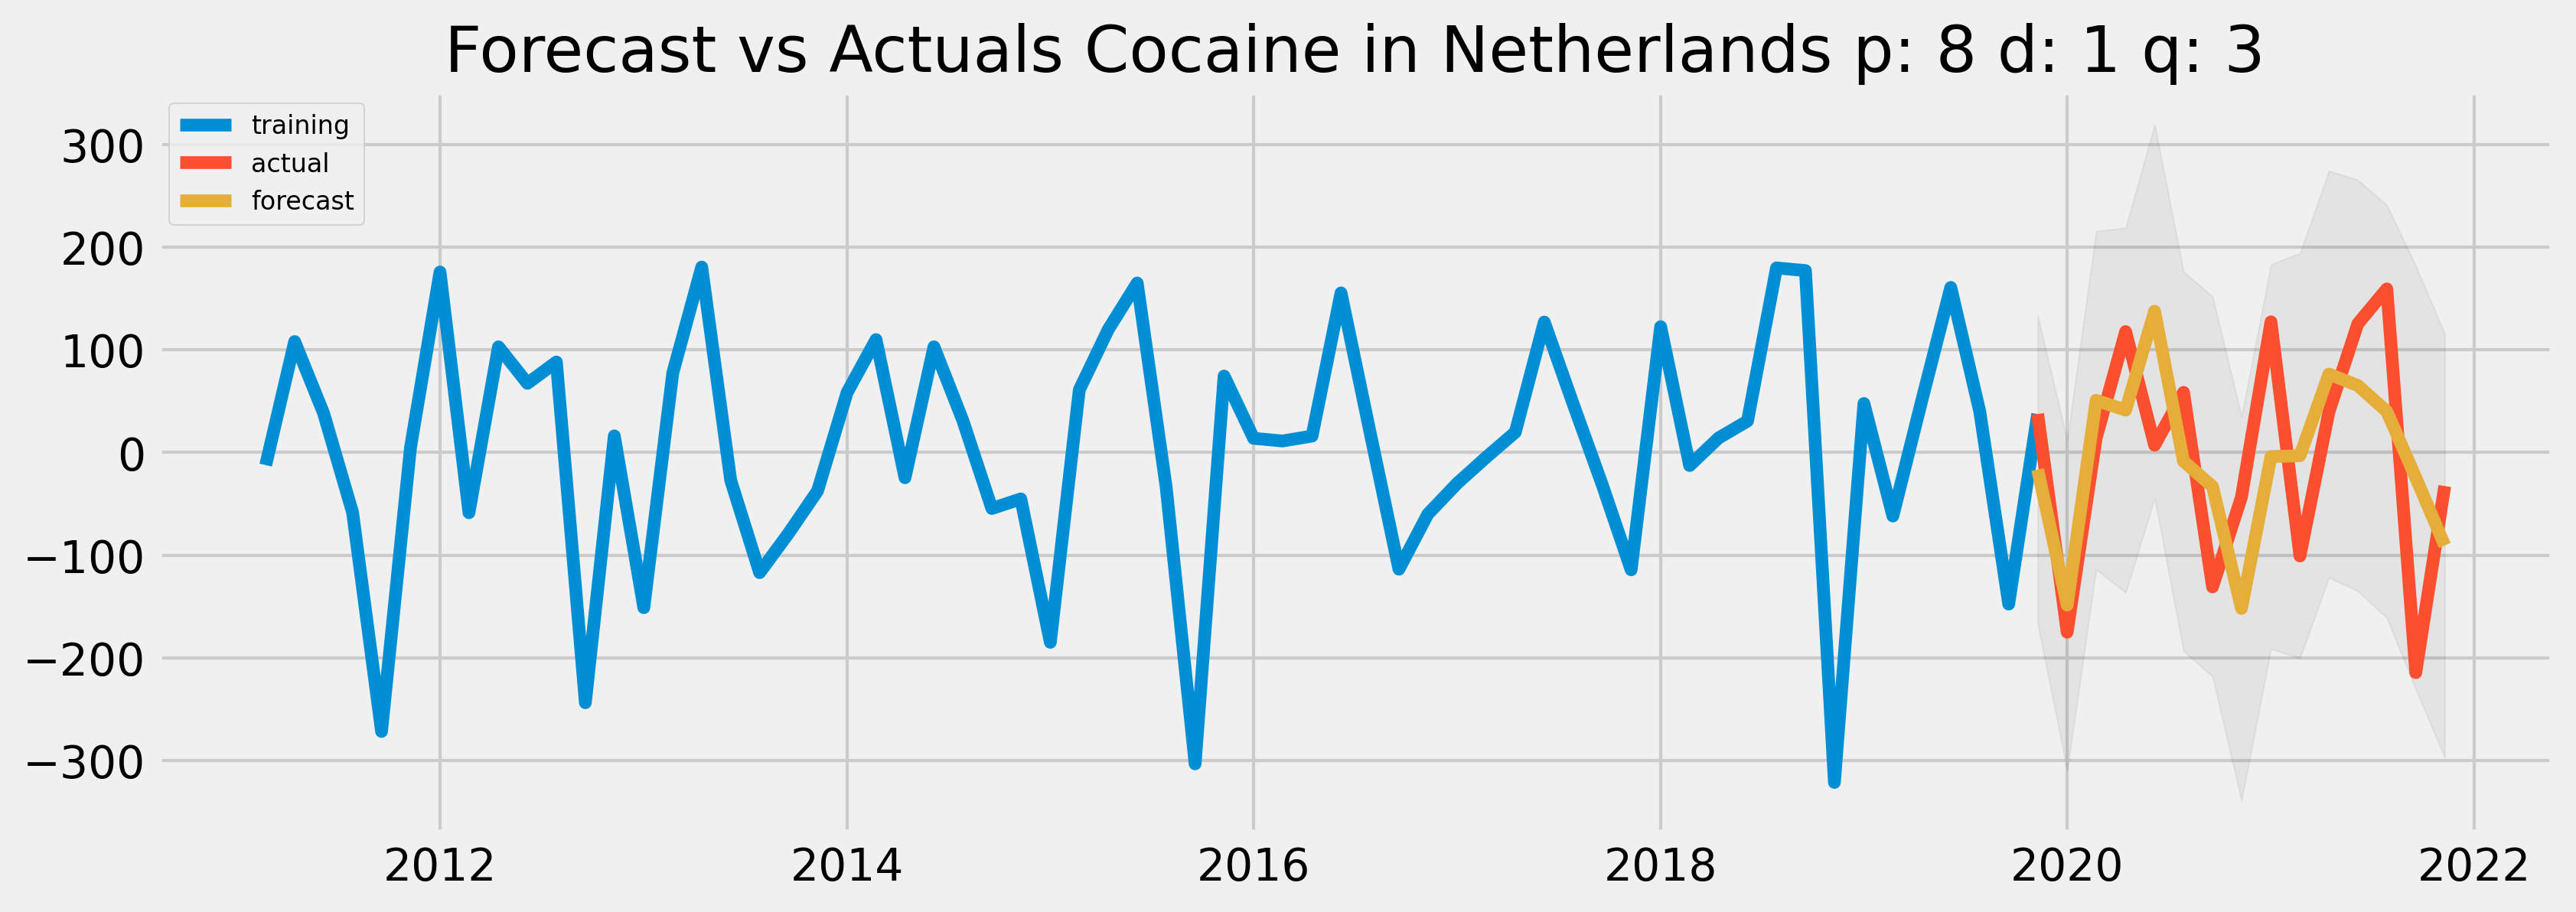

In [422]:
hit = 2
p = 8
d = 1
q = 3

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.figure(figsize=(12,4), dpi=300)
plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[2]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[2]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

<h3>
    Time Series Forecast - MDMA in Netherlands
</h3>

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   61
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -339.980
Method:                       css-mle   S.D. of innovations             61.609
Date:                Wed, 24 Aug 2022   AIC                            687.959
Time:                        21:24:58   BIC                            696.403
Sample:                             1   HQIC                           691.268
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0308      0.441      0.070      0.944      -0.834       0.895
ar.L1.D.value     0.0091      0.129      0.071      0.943      -0.243       0.261
ma.L1.D.value    -1.0000      0.041    -

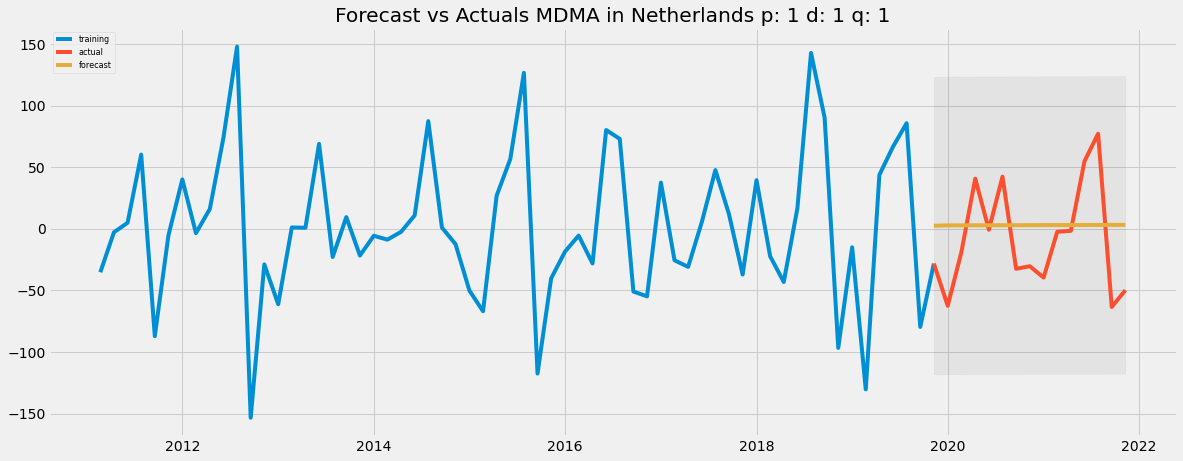

In [423]:
hit = 3
p = 1
d = 1
q = 1

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[3]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[3]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   61
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -328.891
Method:                       css-mle   S.D. of innovations             47.517
Date:                Wed, 24 Aug 2022   AIC                            671.783
Time:                        21:24:58   BIC                            686.559
Sample:                             1   HQIC                           677.574
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0522      0.048      1.084      0.278      -0.042       0.147
ar.L1.D.value     0.5458      0.139      3.921      0.000       0.273       0.819
ar.L2.D.value    -0.2273      0.137     

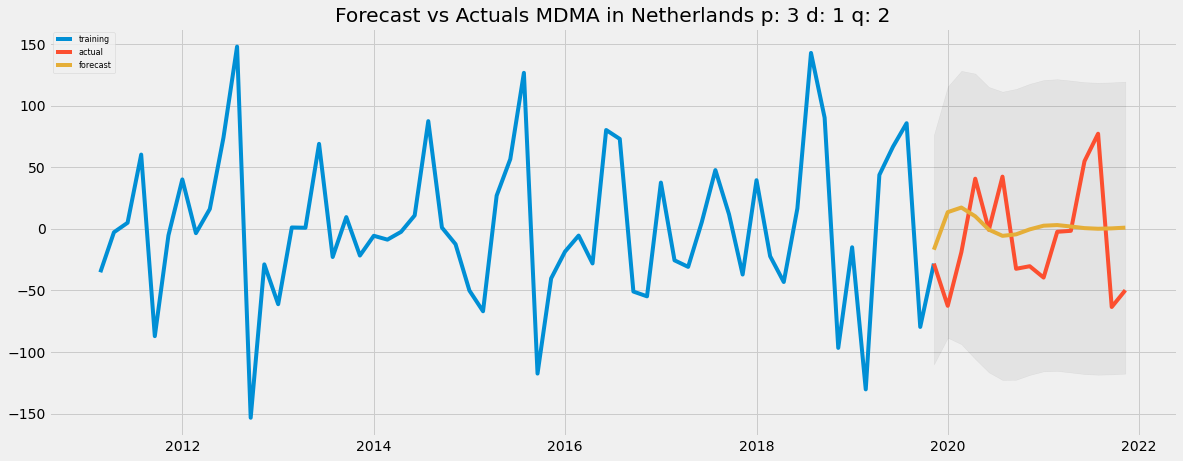

In [424]:
hit = 3
p = 3
d = 1
q = 2

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[3]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[3]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   61
Model:                 ARIMA(3, 1, 6)   Log Likelihood                -324.758
Method:                       css-mle   S.D. of innovations             44.661
Date:                Wed, 24 Aug 2022   AIC                            671.517
Time:                        21:25:09   BIC                            694.736
Sample:                             1   HQIC                           680.617
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0720      0.292      0.247      0.805      -0.500       0.644
ar.L1.D.value    -0.7330      0.430     -1.705      0.088      -1.575       0.109
ar.L2.D.value    -1.1292      0.190     

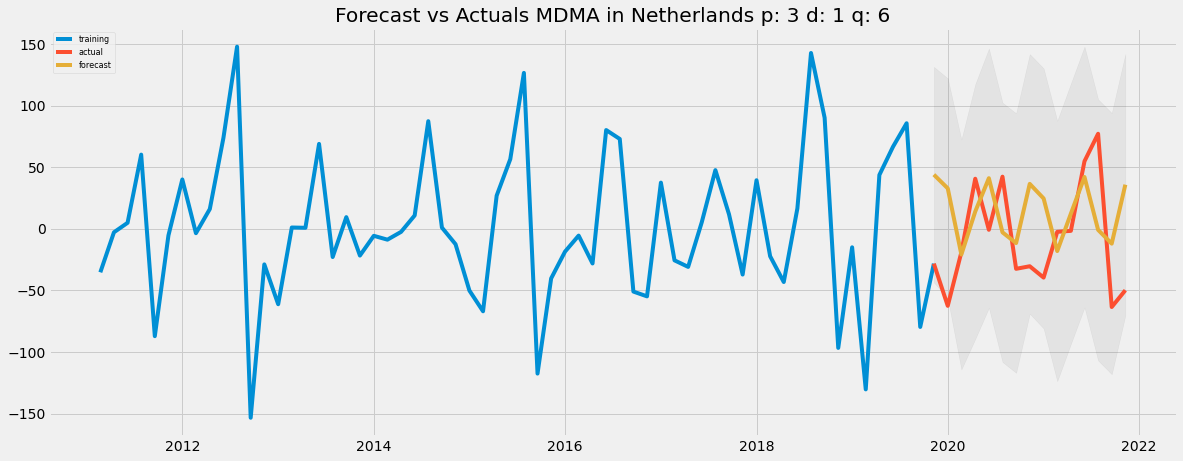

In [425]:
hit = 3
p = 3
d = 1
q = 6

model = ARIMA(dfs_train[hit],order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(len(dfs_test[hit]), alpha = 0.05)

fc_series = pd.Series(fc, index=dfs_test[hit].index)
lower_series = pd.Series(conf[:, 0], index=dfs_test[hit].index)
upper_series = pd.Series(conf[:, 1], index=dfs_test[hit].index)

plt.plot(dfs_train[hit], label='training');
plt.plot(dfs_test[hit], label='actual');
plt.plot(fc_series, label='forecast');
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05);
plt.title('Forecast vs Actuals '+df_ts_name_list[3]+' p: '+str(p)+' d: '+str(d)+' q: '+str(q));
plt.legend(loc='upper left', fontsize=8);
plt.savefig(os.path.join(path,'04 Analysis','01 Visualizations','06 Time Series Forecast','Forecast vs Actuals '+df_ts_name_list[3]+' p '+str(p)+' d '+str(d)+' q '+str(q)+'.jpg'),bbox_inches='tight')
plt.show();

<h2>
    <font color=0096FF>
        <a href='#start'>6. Discussing the Results</a><a id='sixth_chapter'></a>
    </font>
</h2>

The forecast algorithm faces two difficulties:
<ul>
    <li>
        Few observations
    </li>
    <li>
        Not much seasonality in the overall data. Yes, we added the additional observations of the weekdays, but some of the forecasts are still rather disappointing, even with iterating
    </li>
</ul>
<p>
    <b>The results:</b>
<p>
    The Cocaine consumption in Belgium has the best results with p=3 and q=3. At p=5 and q=3 the forecast already seems to be having troubles in predicting truthful results. And even with p=3 and q=3 the actual data line isn't even in the variance of the forecast. Nevertheless, the coefficients were statistically significant - However, some of the coefficients were not available, which could be a hint to data difficulties.
<br>
    Additionally, much of the iteration variations ended in errors, not giving any results.
<p>
    The MDMA consumption in Belgium allowed more iterations than the Cocaine time series till the algorithm faced errors. However, the ARMA forecast variance doesn't cover most of the actual results. Still the best algorithm as done with p=7 and q=3. The coefficients were, apart from the second model, statistically significant as well.
<p>
    The Cocaine consumption in Netherlands was by far the best result. Allowing many iterations and one which variances cover all of the actual data at p=8 and q=1. Here we also get the best results regarding the statistical significance of the coefficients.
<p>
    The MDMA consumption in Netherlands got the worst results. Most of the coefficients are not statistically significant. Although the variance of the forecast aligns with the actual results, the forecast line is rather off topic.
<p>
    <b>Possible next steps:</b>
<br>
It is possible to do more corrections rounds, although the dickey fuller test statistic was on all dataframes even below the 1% critical value, more corrections leave an opportunity to do further work.
<br>
    Despite this, it obvious that more data is needed to get a better result. Besides the option to synthetically increase the dataframe - the increase is synthetical and not authentic. More authentic data allows a better analysis.